# 🔬 Nuclear Reactor Monte Carlo Simulation
## A Branching Brownian Motion and Queue Model Analysis

---

### Project Overview

This notebook implements a **Monte Carlo simulation** of a simplified 2D nuclear reactor model that combines:

1. **Branching Brownian Motion** - Neutrons diffuse randomly in the reactor core
2. **Branching Process** - Neutrons can be absorbed, cause fission (producing offspring), or survive
3. **M/M/1 Queue Dynamics** - External neutron source (particle gun) with arrival/firing rates

### Mathematical Model

**Neutron Movement (Euler-Maruyama Discretization):**
$$X_{n+1}^{(i)} = X_n^{(i)} + \sqrt{2D\Delta t} \cdot Z_n^{(i)}, \quad Z_n^{(i)} \sim \mathcal{N}(0, I_2)$$

**Reaction Probabilities per time step:**
- Absorbed with probability $p_{abs}$ → neutron disappears
- Fission with probability $p_{fiss}$ → produces $K \sim \text{Poisson}(m)$ offspring
- Survives with probability $1 - p_{abs} - p_{fiss}$

**Effective Reproduction Number:**
$$m_{eff} = p_{fiss} \cdot \mathbb{E}[K]$$

- $m_{eff} < 1$: Subcritical (population dies out)
- $m_{eff} \approx 1$: Critical
- $m_{eff} > 1$: Supercritical (population explodes)

### Safety Regimes

| Outcome | Condition |
|---------|----------|
| **Meltdown** | $\max_{0 \leq n \leq T} N_n \geq N_{max}$ |
| **Shutdown** | $N_n = 0$ and $Q_n = 0$ for some $n < T$ |
| **Critical/Safe** | $N_n \in (0, N_{max})$ for all $n \leq T$ |

---
## 1. Setup and Imports

In [2]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyArrowPatch, Polygon
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from dataclasses import dataclass
import dataclasses
from typing import Tuple, List, Dict, Optional
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100

print("✓ All imports successful!")
print(f"NumPy version: {np.__version__}")

✓ All imports successful!
NumPy version: 1.26.4


---
## 2. Core Classes and Data Structures

In [3]:
class Outcome(Enum):
    """Possible outcomes of a reactor simulation run."""
    MELTDOWN = "meltdown"
    SHUTDOWN = "shutdown"
    CRITICAL = "critical"


@dataclass
class SimulationParams:
    """
    Parameters for the nuclear reactor simulation.

    Attributes:
        L: Domain size [0, L] × [0, L]
        D: Diffusion coefficient
        dt: Time step size
        p_abs: Absorption probability per step
        p_fiss: Fission probability per step
        K_mean: Mean offspring per fission (Poisson parameter)
        lambda_in: Arrival rate to neutron gun queue
        mu_fire: Firing rate from gun to core
        T: Time horizon (number of steps)
        N_max: Meltdown threshold
        N_init: Initial neutrons in core
        Q_init: Initial queue length
        boundary: Boundary condition ('reflecting' or 'absorbing')
    """
    # Domain parameters
    L: float = 10.0

    # Physics parameters
    D: float = 1.0
    dt: float = 0.01
    p_abs: float = 0.02
    p_fiss: float = 0.015
    K_mean: float = 2.5

    # Queue parameters
    lambda_in: float = 5.0
    mu_fire: float = 8.0

    # Simulation parameters
    T: int = 5000
    N_max: int = 5000
    N_init: int = 10
    Q_init: int = 5

    # Boundary condition
    boundary: str = 'reflecting'

    # Entry point for fired neutrons
    entry_point: Tuple[float, float] = None

    def __post_init__(self):
        if self.entry_point is None:
            self.entry_point = (0.5, self.L / 2)

    @property
    def m_eff(self) -> float:
        """Effective reproduction number: m_eff = p_fiss × E[K]"""
        return self.p_fiss * self.K_mean

    @property
    def step_std(self) -> float:
        """Standard deviation of Brownian step: σ = √(2D·dt)"""
        return np.sqrt(2 * self.D * self.dt)

    def display(self):
        """Pretty print all parameters."""
        print("╔" + "═" * 50 + "╗")
        print("║" + " SIMULATION PARAMETERS ".center(50) + "║")
        print("╠" + "═" * 50 + "╣")
        print(f"║  Domain: [0, {self.L}] × [0, {self.L}]".ljust(51) + "║")
        print(f"║  Diffusion coefficient D = {self.D}".ljust(51) + "║")
        print(f"║  Time step dt = {self.dt}".ljust(51) + "║")
        print(f"║  Step std σ = √(2D·dt) = {self.step_std:.4f}".ljust(51) + "║")
        print("╠" + "═" * 50 + "╣")
        print(f"║  Absorption probability p_abs = {self.p_abs}".ljust(51) + "║")
        print(f"║  Fission probability p_fiss = {self.p_fiss}".ljust(51) + "║")
        print(f"║  Mean offspring K ~ Poisson({self.K_mean})".ljust(51) + "║")
        print(f"║  Effective reproduction m_eff = {self.m_eff:.4f}".ljust(51) + "║")
        print("╠" + "═" * 50 + "╣")
        print(f"║  Arrival rate λ_in = {self.lambda_in}".ljust(51) + "║")
        print(f"║  Firing rate μ_fire = {self.mu_fire}".ljust(51) + "║")
        print("╠" + "═" * 50 + "╣")
        print(f"║  Time horizon T = {self.T}".ljust(51) + "║")
        print(f"║  Meltdown threshold N_max = {self.N_max}".ljust(51) + "║")
        print(f"║  Initial neutrons N_init = {self.N_init}".ljust(51) + "║")
        print(f"║  Initial queue Q_init = {self.Q_init}".ljust(51) + "║")
        print(f"║  Boundary condition: {self.boundary}".ljust(51) + "║")
        print("╚" + "═" * 50 + "╝")


@dataclass
class SimulationResult:
    """Results from a single simulation run."""
    outcome: Outcome
    population_history: List[int]
    queue_history: List[int]
    final_step: int
    max_population: int
    neutron_paths: Optional[List[Tuple[List[float], List[float]]]] = None
    fission_events: Optional[List[Tuple[float, float, int]]] = None
    absorption_events: Optional[List[Tuple[float, float, int]]] = None


print("✓ Core data structures defined!")

✓ Core data structures defined!


---
## 3. Neutron Class - Individual Particle Dynamics

In [4]:
class Neutron:
    """
    Represents a single neutron in the reactor core.

    Each neutron has:
    - Position (x, y) in the 2D domain
    - History of positions for trajectory visualization
    - Alive/dead state
    """

    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        self.history_x = [x]
        self.history_y = [y]
        self.alive = True
        self.generation = 0  # Track generation for visualization



    def move(self, params: SimulationParams) -> None:
        """
        Move neutron according to Brownian motion.

        Euler-Maruyama discretization:
        X_{n+1} = X_n + √(2D·dt) · Z_n, where Z_n ~ N(0, I_2)
        """
        if not self.alive:
            return

        # Brownian increment
        dx = params.step_std * np.random.randn()
        dy = params.step_std * np.random.randn()

        new_x = self.x + dx
        new_y = self.y + dy

        # Apply boundary conditions
        if params.boundary == 'reflecting':
            new_x = self._reflect(new_x, 0, params.L)
            new_y = self._reflect(new_y, 0, params.L)
        elif params.boundary == 'absorbing':
            if new_x < 0 or new_x > params.L or new_y < 0 or new_y > params.L:
                self.alive = False
                return

        self.x = new_x
        self.y = new_y
        self.history_x.append(self.x)
        self.history_y.append(self.y)

    @staticmethod
    def _reflect(val: float, lo: float, hi: float) -> float:
        """Reflect value back into [lo, hi] domain."""
        while val < lo or val > hi:
            if val < lo:
                val = 2 * lo - val
            if val > hi:
                val = 2 * hi - val
        return val

    def react(self, params: SimulationParams) -> Tuple[List['Neutron'], str]:
        """
        Perform reaction step.

        Returns:
            Tuple of (list of offspring neutrons, event type)
            Event types: 'absorbed', 'fission', 'survived'
        """
        if not self.alive:
            return [], 'dead'

        r = np.random.random()

        if r < params.p_abs:
            # Absorbed - neutron dies
            self.alive = False
            return [], 'absorbed'

        elif r < params.p_abs + params.p_fiss:
            # Fission - neutron dies, produces K offspring
            self.alive = False
            K = np.random.poisson(params.K_mean)
            offspring = []
            for _ in range(K):
                # Small random displacement for offspring
                ox = np.clip(self.x + 0.1 * np.random.randn(), 0, params.L)
                oy = np.clip(self.y + 0.1 * np.random.randn(), 0, params.L)
                child = Neutron(ox, oy)
                child.generation = self.generation + 1
                offspring.append(child)
            return offspring, 'fission'

        else:
            # Survives unchanged
            return [], 'survived'


print("✓ Neutron class defined!")

✓ Neutron class defined!


---
## 4. Reactor Simulator - Main Simulation Engine

In [5]:
class ReactorSimulator:
    """
    Main simulator class for the nuclear reactor model.

    Combines:
    - Branching Brownian motion for neutron dynamics
    - M/M/1-like queue for external neutron source
    - Monte Carlo estimation for outcome probabilities
    """

    def __init__(self, params: SimulationParams):
        self.params = params

    def run_single(self, track_paths: bool = False,
                   max_paths: int = 50,
                   track_events: bool = False) -> SimulationResult:
        """
        Run a single simulation.

        Args:
            track_paths: Whether to track neutron trajectories
            max_paths: Maximum number of paths to track
            track_events: Whether to track fission/absorption events

        Returns:
            SimulationResult with outcome and histories
        """
        params = self.params

        # Initialize neutrons in core (random positions)
        neutrons = []
        for _ in range(params.N_init):
            x = np.random.uniform(0, params.L)
            y = np.random.uniform(0, params.L)
            neutrons.append(Neutron(x, y))

        # Initialize queue
        queue_length = params.Q_init

        # History tracking
        population_history = [len(neutrons)]
        queue_history = [queue_length]

        # Track paths and events
        tracked_neutrons = neutrons[:max_paths] if track_paths else []
        fission_events = [] if track_events else None
        absorption_events = [] if track_events else None

        outcome = Outcome.CRITICAL
        final_step = params.T

        for step in range(params.T):
            # === Queue dynamics ===
            # New arrivals to queue (Poisson)
            arrivals = np.random.poisson(params.lambda_in * params.dt)
            queue_length += arrivals

            # Fire neutrons from queue to core
            if queue_length > 0:
                n_fire = min(
                    np.random.poisson(params.mu_fire * params.dt),
                    queue_length
                )
                queue_length -= n_fire

                # Add fired neutrons at entry point
                for _ in range(n_fire):
                    ex, ey = params.entry_point
                    nx = np.clip(ex + 0.2 * np.random.randn(), 0, params.L)
                    ny = np.clip(ey + 0.2 * np.random.randn(), 0, params.L)
                    new_neutron = Neutron(nx, ny)
                    neutrons.append(new_neutron)
                    if track_paths and len(tracked_neutrons) < max_paths:
                        tracked_neutrons.append(new_neutron)

            # === Neutron dynamics ===
            # Move all neutrons
            for n in neutrons:
                n.move(params)

            # Reactions
            offspring = []
            for n in neutrons:
                children, event = n.react(params)
                offspring.extend(children)

                if track_events:
                    if event == 'fission':
                        fission_events.append((n.x, n.y, step))
                    elif event == 'absorbed':
                        absorption_events.append((n.x, n.y, step))

            # Update neutron list
            neutrons = [n for n in neutrons if n.alive] + offspring

            # Track offspring paths
            if track_paths:
                for o in offspring:
                    if len(tracked_neutrons) < max_paths:
                        tracked_neutrons.append(o)

            # Record history
            N = len(neutrons)
            population_history.append(N)
            queue_history.append(queue_length)

            # Check termination conditions
            if N >= params.N_max:
                outcome = Outcome.MELTDOWN
                final_step = step + 1
                break

            if N == 0 and queue_length == 0:
                outcome = Outcome.SHUTDOWN
                final_step = step + 1
                break

        # Extract paths
        neutron_paths = None
        if track_paths:
            neutron_paths = [
                (n.history_x, n.history_y)
                for n in tracked_neutrons
                if len(n.history_x) > 1
            ]

        return SimulationResult(
            outcome=outcome,
            population_history=population_history,
            queue_history=queue_history,
            final_step=final_step,
            max_population=max(population_history),
            neutron_paths=neutron_paths,
            fission_events=fission_events,
            absorption_events=absorption_events
        )

    def run_monte_carlo(self, M: int = 1000, verbose: bool = True) -> Dict:
        """
        Run M independent simulations and compute statistics.

        Returns:
            Dictionary with probabilities, confidence intervals, and statistics
        """
        outcomes = {Outcome.MELTDOWN: 0, Outcome.SHUTDOWN: 0, Outcome.CRITICAL: 0}
        max_pops = []
        final_steps = []

        for i in range(M):
            if verbose and (i + 1) % 100 == 0:
                print(f"  Progress: {i + 1}/{M} ({100*(i+1)/M:.0f}%)")

            result = self.run_single(track_paths=False)
            outcomes[result.outcome] += 1
            max_pops.append(result.max_population)
            final_steps.append(result.final_step)

        # Compute probabilities and confidence intervals
        results = {}
        for outcome in Outcome:
            count = outcomes[outcome]
            p_hat = count / M
            ci_low, ci_high = self._wilson_ci(count, M, 0.95)
            se = np.sqrt(p_hat * (1 - p_hat) / M)

            results[outcome.value] = {
                'count': count,
                'probability': p_hat,
                'std_error': se,
                'ci_95': (ci_low, ci_high)
            }

        results['max_population'] = {
            'mean': np.mean(max_pops),
            'std': np.std(max_pops),
            'median': np.median(max_pops),
            'max': np.max(max_pops)
        }

        results['final_step'] = {
            'mean': np.mean(final_steps),
            'std': np.std(final_steps)
        }

        results['M'] = M

        return results

    @staticmethod
    def _wilson_ci(successes: int, n: int, confidence: float) -> Tuple[float, float]:
        """Wilson score confidence interval for proportions."""
        if n == 0:
            return (0.0, 1.0)

        z = stats.norm.ppf(1 - (1 - confidence) / 2)
        p_hat = successes / n

        denom = 1 + z**2 / n
        center = (p_hat + z**2 / (2 * n)) / denom
        margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n)) / n) / denom

        return (max(0, center - margin), min(1, center + margin))


print("✓ ReactorSimulator class defined!")

✓ ReactorSimulator class defined!


### Annealing

In [6]:
# === Simulated annealing: objective for (p_fiss, p_abs) ===


def evaluate_fiss_abs(p_fiss: float,
                      p_abs: float,
                      base_params: SimulationParams,
                      M_eval: int = 20,
                      bounds_fiss=(0.0, 0.05),
                      bounds_abs=(0.0, 0.10),
                      weights=(5.0, 1.0, 2.0, 1.0)) -> float:
    """
    Evaluate a candidate (p_fiss, p_abs) by running a small Monte Carlo
    and computing a 'reactor quality' cost.

    Lower is better:
      - penalizes meltdowns strongly
      - penalizes shutdowns mildly
      - rewards critical operation & longer lifetime
    """

    # clamp parameters to reasonable ranges
    p_fiss = float(np.clip(p_fiss, *bounds_fiss))
    p_abs  = float(np.clip(p_abs,  *bounds_abs))

    # copy params with modified values
    params = dataclasses.replace(base_params, p_fiss=p_fiss, p_abs=p_abs)

    sim = ReactorSimulator(params)
    mc = sim.run_monte_carlo(M=M_eval, verbose=False)

    p_melt = mc["meltdown"]["probability"]
    p_shut = mc["shutdown"]["probability"]
    p_crit = mc["critical"]["probability"]
    mean_final_step = mc["final_step"]["mean"]

    w_melt, w_shut, w_crit, w_time = weights

    # normalise mean_final_step by total horizon T so it's in [0,1]
    norm_time = mean_final_step / params.T

    # scalar cost: lower is better
    J = (
        w_melt * p_melt +
        w_shut * p_shut -
        w_crit * p_crit -
        w_time * norm_time
    )

    return J


# === 2D simulated annealing over (p_fiss, p_abs) ===

def sa_optimize_fiss_abs(base_params: SimulationParams,
                         p_fiss_init: float = None,
                         p_abs_init: float = None,
                         M_eval: int = 10,
                         max_iters: int = 25,
                         T0: float = 0.5,
                         alpha: float = 0.9,
                         step_fiss: float = 0.001,
                         step_abs: float = 0.001,
                         bounds_fiss=(0.0, 0.05),
                         bounds_abs=(0.0, 0.10)):
    """
    Lightweight simulated annealing to find a 'good' pair (p_fiss, p_abs):
    - low meltdown
    - not too much shutdown
    - reasonably long lifetime
    """

    if p_fiss_init is None:
        p_fiss_init = base_params.p_fiss
    if p_abs_init is None:
        p_abs_init = base_params.p_abs

    # initial solution
    cur_pf = float(np.clip(p_fiss_init, *bounds_fiss))
    cur_pa = float(np.clip(p_abs_init,  *bounds_abs))

    cur_cost = evaluate_fiss_abs(cur_pf, cur_pa, base_params,
                                 M_eval=M_eval,
                                 bounds_fiss=bounds_fiss,
                                 bounds_abs=bounds_abs)

    best_pf, best_pa = cur_pf, cur_pa
    best_cost = cur_cost

    history = []

    for k in range(max_iters):
        T = T0 * (alpha ** k)

        # propose neighbour in 2D
        cand_pf = cur_pf + step_fiss * np.random.randn()
        cand_pa = cur_pa + step_abs  * np.random.randn()

        cand_pf = float(np.clip(cand_pf, *bounds_fiss))
        cand_pa = float(np.clip(cand_pa, *bounds_abs))

        cand_cost = evaluate_fiss_abs(cand_pf, cand_pa, base_params,
                                      M_eval=M_eval,
                                      bounds_fiss=bounds_fiss,
                                      bounds_abs=bounds_abs)

        delta = cand_cost - cur_cost  # we minimize

        if delta <= 0:
            accept = True
        else:
            accept_prob = np.exp(-delta / T) if T > 0 else 0.0
            accept = (np.random.rand() < accept_prob)

        if accept:
            cur_pf, cur_pa, cur_cost = cand_pf, cand_pa, cand_cost

        if cur_cost < best_cost:
            best_pf, best_pa, best_cost = cur_pf, cur_pa, cur_cost

        history.append({
            "iter": k,
            "T": T,
            "cur_pf": cur_pf,
            "cur_pa": cur_pa,
            "cur_cost": cur_cost,
            "best_pf": best_pf,
            "best_pa": best_pa,
            "best_cost": best_cost,
        })

        print(
            f"iter {k:3d} | T={T:.3f} | p_fiss={cur_pf:.5f}, p_abs={cur_pa:.5f} | "
            f"J={cur_cost:.3f} | best J={best_cost:.3f}"
        )

    return {
        "best_p_fiss": best_pf,
        "best_p_abs": best_pa,
        "best_cost": best_cost,
        "history": history,
    }


---
## 5. Statistical Testing Functions

In [7]:
def two_sample_proportion_test(n1: int, x1: int, n2: int, x2: int) -> Dict:
    """
    Two-sample z-test for proportions.

    H0: p1 = p2  vs  H1: p1 ≠ p2

    Args:
        n1, n2: Sample sizes
        x1, x2: Number of successes

    Returns:
        Dictionary with test statistics and p-value
    """
    p1 = x1 / n1
    p2 = x2 / n2

    # Pooled proportion under H0
    p_pool = (x1 + x2) / (n1 + n2)

    # Standard error
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

    if se == 0:
        return {'z_stat': np.nan, 'p_value': 1.0, 'significant_05': False}

    # Z statistic
    z = (p1 - p2) / se

    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))

    return {
        'p1': p1,
        'p2': p2,
        'difference': p1 - p2,
        'pooled_p': p_pool,
        'std_error': se,
        'z_stat': z,
        'p_value': p_value,
        'significant_05': p_value < 0.05,
        'significant_01': p_value < 0.01
    }


def print_hypothesis_test(test_result: Dict, label: str):
    """Pretty print hypothesis test results."""
    print(f"\n  {label}:")
    print(f"    p̂₁ = {test_result['p1']:.4f}")
    print(f"    p̂₂ = {test_result['p2']:.4f}")
    print(f"    Difference = {test_result['difference']:.4f}")
    print(f"    Z-statistic = {test_result['z_stat']:.4f}")
    print(f"    p-value = {test_result['p_value']:.6f}")
    print(f"    Significant at α=0.05? {'✓ YES' if test_result['significant_05'] else '✗ NO'}")
    print(f"    Significant at α=0.01? {'✓ YES' if test_result['significant_01'] else '✗ NO'}")


print("✓ Statistical testing functions defined!")

✓ Statistical testing functions defined!


---
## 6. Initialize Simulation Parameters

In [8]:
# Create base simulation parameters
params = SimulationParams(
    L=10.0,           # 10x10 domain
    D=1.0,            # Diffusion coefficient
    dt=0.01,          # Time step
    p_abs=0.02,       # 2% absorption probability per step
    p_fiss=0.015,     # 1.5% fission probability per step
    K_mean=2.5,       # Average 2.5 offspring per fission
    lambda_in=5.0,    # Neutron arrival rate
    mu_fire=8.0,      # Neutron firing rate
    T=5000,           # Time horizon
    N_max=5000,       # Meltdown threshold
    N_init=10,        # Initial neutrons
    Q_init=5,         # Initial queue
    boundary='reflecting'
)

# Display parameters
params.display()

# Analyze criticality
print(f"\n📊 Criticality Analysis:")
print(f"   m_eff = {params.m_eff:.4f}")
if params.m_eff < 1:
    print(f"   Status: SUBCRITICAL (m_eff < 1)")
    print(f"   Expected behavior: Population tends to die out")
elif params.m_eff > 1:
    print(f"   Status: SUPERCRITICAL (m_eff > 1)")
    print(f"   Expected behavior: Population tends to explode")
else:
    print(f"   Status: CRITICAL (m_eff ≈ 1)")
    print(f"   Expected behavior: Population stays roughly constant")

╔══════════════════════════════════════════════════╗
║              SIMULATION PARAMETERS               ║
╠══════════════════════════════════════════════════╣
║  Domain: [0, 10.0] × [0, 10.0]                   ║
║  Diffusion coefficient D = 1.0                   ║
║  Time step dt = 0.01                             ║
║  Step std σ = √(2D·dt) = 0.1414                  ║
╠══════════════════════════════════════════════════╣
║  Absorption probability p_abs = 0.02             ║
║  Fission probability p_fiss = 0.015              ║
║  Mean offspring K ~ Poisson(2.5)                 ║
║  Effective reproduction m_eff = 0.0375           ║
╠══════════════════════════════════════════════════╣
║  Arrival rate λ_in = 5.0                         ║
║  Firing rate μ_fire = 8.0                        ║
╠══════════════════════════════════════════════════╣
║  Time horizon T = 5000                           ║
║  Meltdown threshold N_max = 5000                 ║
║  Initial neutrons N_init = 10               

---
## 7. 🎨 Visualization 1: Pure Brownian Motion Paths

First, let's visualize the fundamental Brownian motion that governs neutron diffusion in the reactor core.

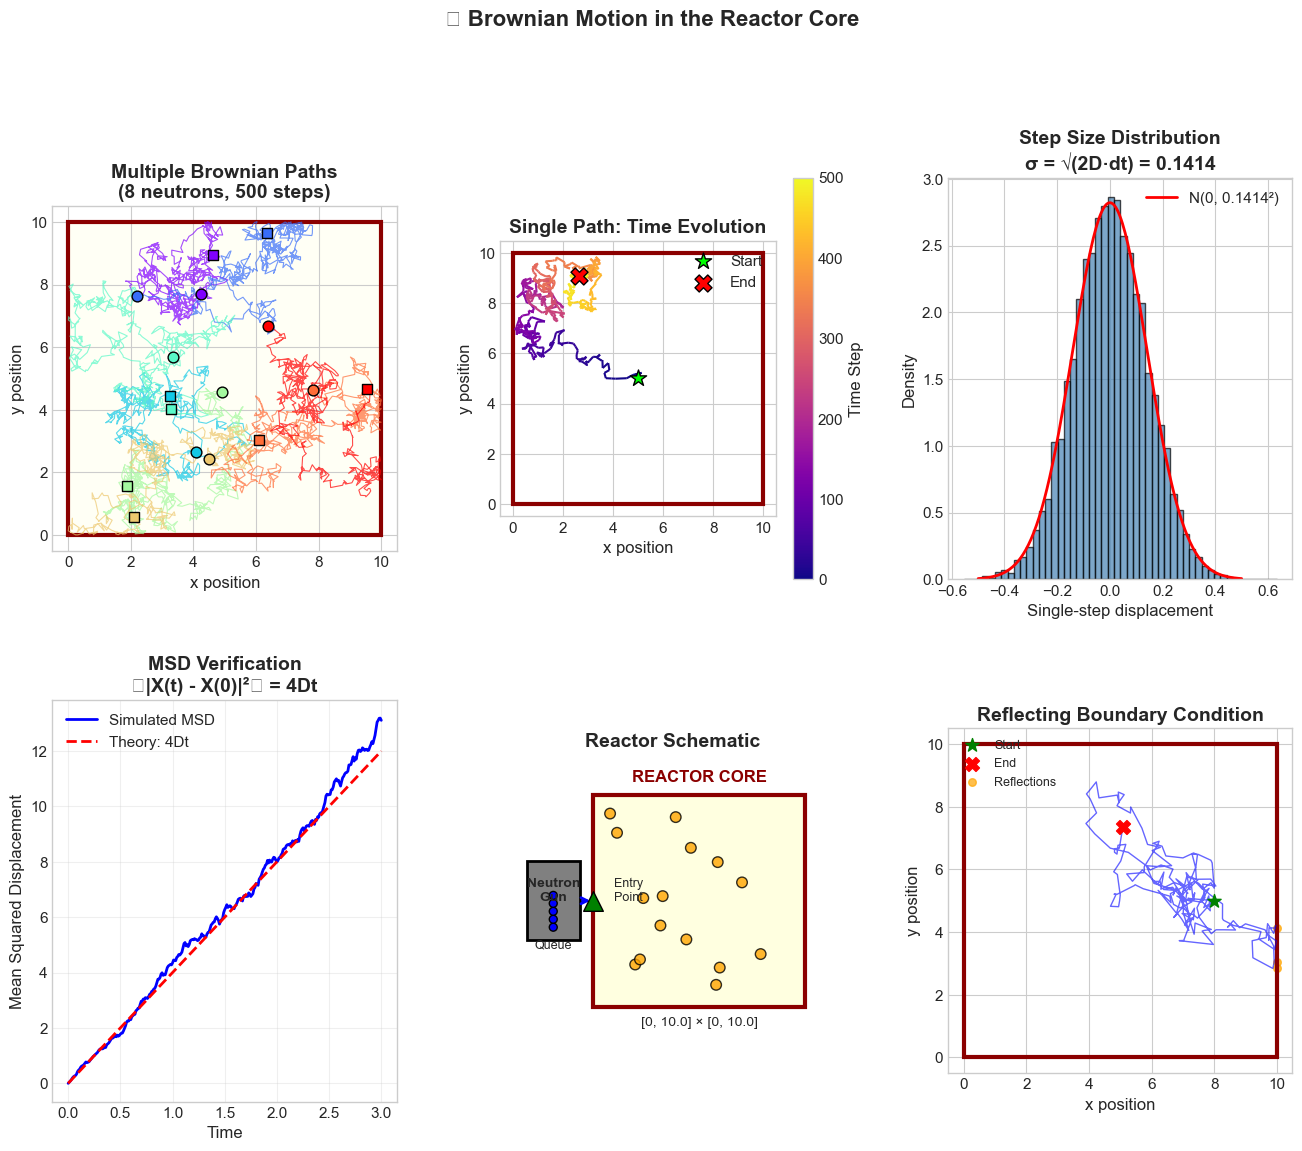

In [10]:
def plot_brownian_motion_showcase(params: SimulationParams):
    """
    Create a comprehensive visualization of Brownian motion in the reactor.
    """
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

    np.random.seed(42)
    n_steps = 500

    # === Panel 1: Multiple Brownian paths ===
    ax1 = fig.add_subplot(gs[0, 0])
    n_paths = 8
    colors = plt.cm.rainbow(np.linspace(0, 1, n_paths))

    for i in range(n_paths):
        x = np.zeros(n_steps + 1)
        y = np.zeros(n_steps + 1)
        x[0] = np.random.uniform(2, 8)
        y[0] = np.random.uniform(2, 8)

        for t in range(n_steps):
            dx = params.step_std * np.random.randn()
            dy = params.step_std * np.random.randn()
            new_x, new_y = x[t] + dx, y[t] + dy

            # Reflecting boundary
            while new_x < 0 or new_x > params.L:
                new_x = abs(new_x) if new_x < 0 else 2*params.L - new_x
            while new_y < 0 or new_y > params.L:
                new_y = abs(new_y) if new_y < 0 else 2*params.L - new_y

            x[t+1], y[t+1] = new_x, new_y

        ax1.plot(x, y, alpha=0.7, linewidth=0.8, color=colors[i])
        ax1.scatter(x[0], y[0], color=colors[i], s=60, marker='o',
                   edgecolor='black', zorder=5)
        ax1.scatter(x[-1], y[-1], color=colors[i], s=60, marker='s',
                   edgecolor='black', zorder=5)

    # Reactor boundary
    rect = Rectangle((0, 0), params.L, params.L, fill=False,
                     edgecolor='darkred', linewidth=3, linestyle='-')
    ax1.add_patch(rect)
    ax1.fill([0, params.L, params.L, 0], [0, 0, params.L, params.L],
            color='lightyellow', alpha=0.3, zorder=0)

    ax1.set_xlim(-0.5, params.L + 0.5)
    ax1.set_ylim(-0.5, params.L + 0.5)
    ax1.set_xlabel('x position')
    ax1.set_ylabel('y position')
    ax1.set_title(f'Multiple Brownian Paths\n({n_paths} neutrons, {n_steps} steps)', fontweight='bold')
    ax1.set_aspect('equal')

    # === Panel 2: Single path with time coloring ===
    ax2 = fig.add_subplot(gs[0, 1])

    x = np.zeros(n_steps + 1)
    y = np.zeros(n_steps + 1)
    x[0], y[0] = params.L/2, params.L/2

    for t in range(n_steps):
        dx = params.step_std * np.random.randn()
        dy = params.step_std * np.random.randn()
        new_x, new_y = x[t] + dx, y[t] + dy

        while new_x < 0 or new_x > params.L:
            new_x = abs(new_x) if new_x < 0 else 2*params.L - new_x
        while new_y < 0 or new_y > params.L:
            new_y = abs(new_y) if new_y < 0 else 2*params.L - new_y

        x[t+1], y[t+1] = new_x, new_y

    # Create colored line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='plasma', norm=Normalize(0, n_steps))
    lc.set_array(np.arange(n_steps))
    lc.set_linewidth(1.5)
    ax2.add_collection(lc)

    cbar = plt.colorbar(lc, ax=ax2, label='Time Step')

    ax2.scatter(x[0], y[0], color='lime', s=150, marker='*',
               edgecolor='black', zorder=10, label='Start')
    ax2.scatter(x[-1], y[-1], color='red', s=150, marker='X',
               edgecolor='black', zorder=10, label='End')

    rect = Rectangle((0, 0), params.L, params.L, fill=False,
                     edgecolor='darkred', linewidth=3)
    ax2.add_patch(rect)

    ax2.set_xlim(-0.5, params.L + 0.5)
    ax2.set_ylim(-0.5, params.L + 0.5)
    ax2.set_xlabel('x position')
    ax2.set_ylabel('y position')
    ax2.set_title('Single Path: Time Evolution', fontweight='bold')
    ax2.set_aspect('equal')
    ax2.legend(loc='upper right')

    # === Panel 3: Displacement distribution ===
    ax3 = fig.add_subplot(gs[0, 2])

    n_samples = 10000
    displacements = params.step_std * np.random.randn(n_samples)

    ax3.hist(displacements, bins=50, density=True, alpha=0.7,
            color='steelblue', edgecolor='black')

    x_theory = np.linspace(-0.5, 0.5, 200)
    y_theory = stats.norm.pdf(x_theory, 0, params.step_std)
    ax3.plot(x_theory, y_theory, 'r-', linewidth=2,
            label=f'N(0, {params.step_std:.4f}²)')

    ax3.set_xlabel('Single-step displacement')
    ax3.set_ylabel('Density')
    ax3.set_title(f'Step Size Distribution\nσ = √(2D·dt) = {params.step_std:.4f}', fontweight='bold')
    ax3.legend()

    # === Panel 4: Mean squared displacement ===
    ax4 = fig.add_subplot(gs[1, 0])

    n_trajectories = 100
    max_t = 300
    msd = np.zeros(max_t + 1)

    for _ in range(n_trajectories):
        x = np.zeros(max_t + 1)
        y = np.zeros(max_t + 1)
        x[0], y[0] = params.L/2, params.L/2

        for t in range(max_t):
            x[t+1] = x[t] + params.step_std * np.random.randn()
            y[t+1] = y[t] + params.step_std * np.random.randn()

        msd += (x - x[0])**2 + (y - y[0])**2

    msd /= n_trajectories

    times = np.arange(max_t + 1) * params.dt
    theoretical_msd = 4 * params.D * times  # 2D Brownian motion: MSD = 4Dt

    ax4.plot(times, msd, 'b-', linewidth=2, label='Simulated MSD')
    ax4.plot(times, theoretical_msd, 'r--', linewidth=2, label='Theory: 4Dt')

    ax4.set_xlabel('Time')
    ax4.set_ylabel('Mean Squared Displacement')
    ax4.set_title('MSD Verification\n⟨|X(t) - X(0)|²⟩ = 4Dt', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # === Panel 5: Reactor schematic ===
    ax5 = fig.add_subplot(gs[1, 1])

    # Reactor core
    core = Rectangle((1, 1), 8, 8, facecolor='lightyellow',
                     edgecolor='darkred', linewidth=3)
    ax5.add_patch(core)

    # Neutron gun
    gun = Rectangle((-1.5, 3.5), 2, 3, facecolor='gray',
                   edgecolor='black', linewidth=2)
    ax5.add_patch(gun)
    ax5.annotate('Neutron\nGun', xy=(-0.5, 5), fontsize=10, ha='center',
                fontweight='bold')

    # Queue visualization
    for i in range(5):
        circle = Circle((-0.5, 4 + i*0.3), 0.15, facecolor='blue',
                       edgecolor='black')
        ax5.add_patch(circle)
    ax5.annotate('Queue', xy=(-0.5, 3.2), fontsize=9, ha='center')

    # Arrow from gun to core
    ax5.annotate('', xy=(1, 5), xytext=(0.5, 5),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))

    # Sample neutrons in core
    np.random.seed(42)
    for _ in range(15):
        nx = np.random.uniform(1.5, 8.5)
        ny = np.random.uniform(1.5, 8.5)
        circle = Circle((nx, ny), 0.2, facecolor='orange',
                       edgecolor='black', alpha=0.8)
        ax5.add_patch(circle)

    # Labels
    ax5.annotate('REACTOR CORE', xy=(5, 9.5), fontsize=12,
                ha='center', fontweight='bold', color='darkred')
    ax5.annotate(f'[0, {params.L}] × [0, {params.L}]', xy=(5, 0.3),
                fontsize=10, ha='center')

    # Entry point
    ex, ey = params.entry_point
    ax5.scatter(1, 5, color='green', s=200, marker='^',
               edgecolor='black', zorder=10)
    ax5.annotate('Entry\nPoint', xy=(1.8, 5), fontsize=9)

    ax5.set_xlim(-2.5, 10.5)
    ax5.set_ylim(-0.5, 10.5)
    ax5.set_aspect('equal')
    ax5.axis('off')
    ax5.set_title('Reactor Schematic', fontweight='bold')

    # === Panel 6: Boundary reflection demo ===
    ax6 = fig.add_subplot(gs[1, 2])

    # Simulate path with boundary reflections
    np.random.seed(789)
    x = [8.0]
    y = [5.0]
    reflections_x = []
    reflections_y = []

    for t in range(200):
        dx = 0.3 * np.random.randn()  # Larger steps to show reflections
        dy = 0.3 * np.random.randn()
        new_x = x[-1] + dx
        new_y = y[-1] + dy

        # Track reflections
        reflected = False
        while new_x < 0 or new_x > params.L:
            if new_x < 0:
                reflections_x.append(0)
                reflections_y.append(new_y)
                new_x = -new_x
            if new_x > params.L:
                reflections_x.append(params.L)
                reflections_y.append(new_y)
                new_x = 2*params.L - new_x
            reflected = True
        while new_y < 0 or new_y > params.L:
            if new_y < 0:
                reflections_x.append(new_x)
                reflections_y.append(0)
                new_y = -new_y
            if new_y > params.L:
                reflections_x.append(new_x)
                reflections_y.append(params.L)
                new_y = 2*params.L - new_y
            reflected = True

        x.append(new_x)
        y.append(new_y)

    ax6.plot(x, y, 'b-', alpha=0.6, linewidth=1)
    ax6.scatter(x[0], y[0], color='green', s=100, marker='*', zorder=5, label='Start')
    ax6.scatter(x[-1], y[-1], color='red', s=100, marker='X', zorder=5, label='End')
    if reflections_x:
        ax6.scatter(reflections_x, reflections_y, color='orange', s=30,
                   marker='o', alpha=0.7, label='Reflections')

    rect = Rectangle((0, 0), params.L, params.L, fill=False,
                     edgecolor='darkred', linewidth=3)
    ax6.add_patch(rect)

    ax6.set_xlim(-0.5, params.L + 0.5)
    ax6.set_ylim(-0.5, params.L + 0.5)
    ax6.set_xlabel('x position')
    ax6.set_ylabel('y position')
    ax6.set_title('Reflecting Boundary Condition', fontweight='bold')
    ax6.set_aspect('equal')
    ax6.legend(loc='upper left', fontsize=9)

    plt.suptitle('🔬 Brownian Motion in the Reactor Core', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('01_brownian_motion.png', dpi=150, bbox_inches='tight')
    plt.show()


# Generate the plot
plot_brownian_motion_showcase(params)

---
## 8. 🎨 Visualization 2: Branching Process Dynamics

Visualize how neutrons undergo fission (branching) and absorption in the reactor.

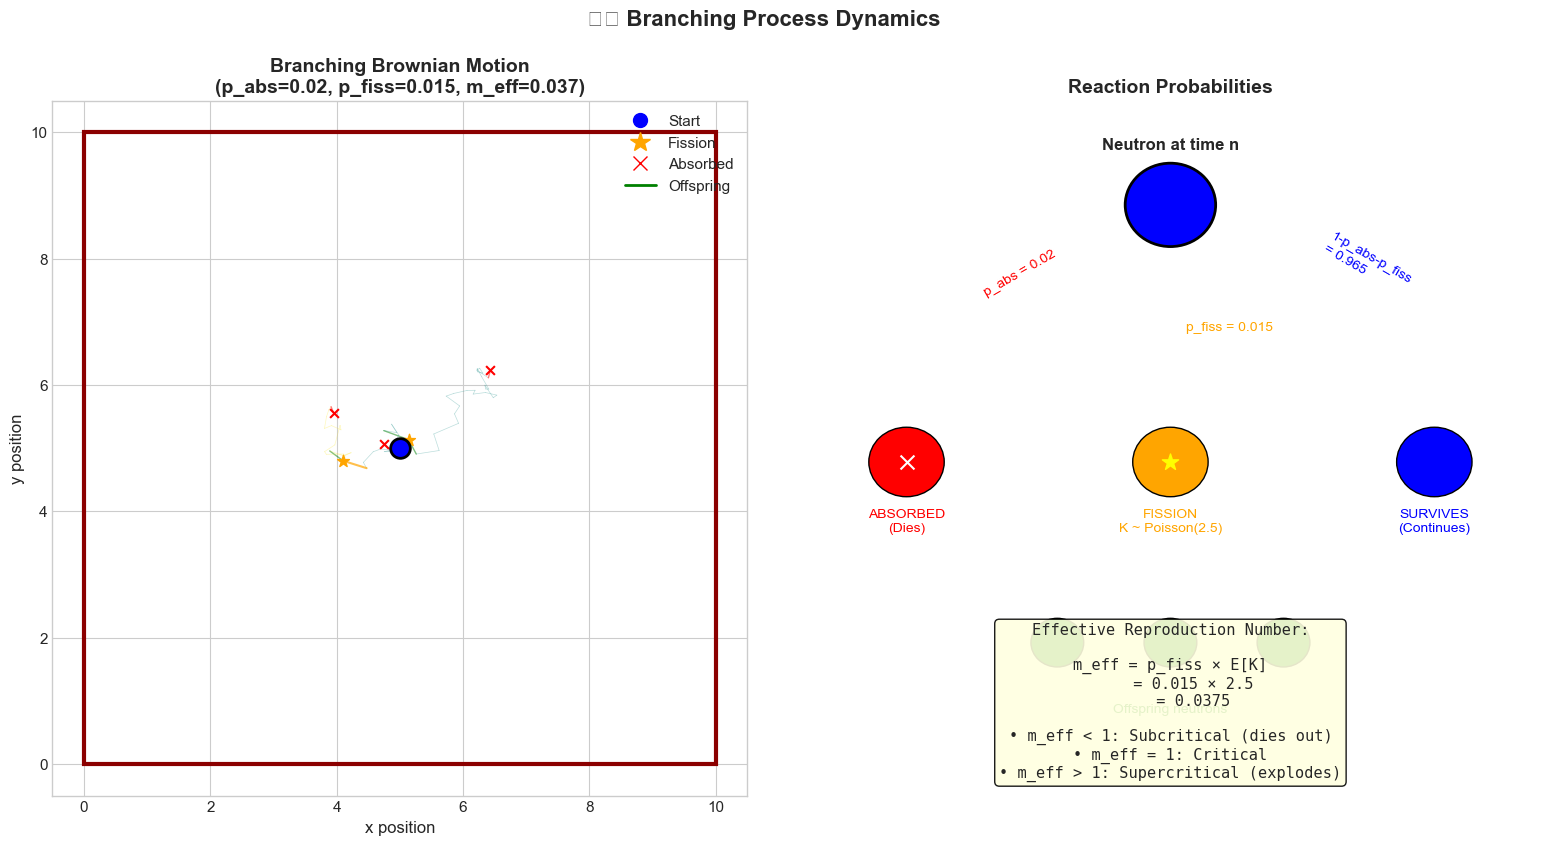

In [11]:
def plot_branching_process(params: SimulationParams):
    """
    Visualize the branching Brownian motion with fission and absorption events.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    np.random.seed(42)

    # === Left: Branching tree in 2D space ===
    ax1 = axes[0]

    # Track particles
    history = []  # (start_pos, end_pos, event_type, generation)
    living = {0: (params.L/2, params.L/2, 0)}  # id -> (x, y, generation)
    next_id = 1

    n_steps = 200

    for t in range(n_steps):
        new_living = {}

        for pid, (x, y, gen) in living.items():
            # Move
            dx = params.step_std * np.random.randn()
            dy = params.step_std * np.random.randn()
            new_x = np.clip(x + dx, 0, params.L)
            new_y = np.clip(y + dy, 0, params.L)

            # Reaction
            r = np.random.random()

            if r < params.p_abs:
                history.append(((x, y), (new_x, new_y), 'absorbed', gen))
            elif r < params.p_abs + params.p_fiss:
                history.append(((x, y), (new_x, new_y), 'fission', gen))
                K = np.random.poisson(params.K_mean)
                for _ in range(K):
                    ox = np.clip(new_x + 0.15 * np.random.randn(), 0, params.L)
                    oy = np.clip(new_y + 0.15 * np.random.randn(), 0, params.L)
                    new_living[next_id] = (ox, oy, gen + 1)
                    history.append(((new_x, new_y), (ox, oy), 'offspring', gen + 1))
                    next_id += 1
            else:
                new_living[pid] = (new_x, new_y, gen)
                history.append(((x, y), (new_x, new_y), 'move', gen))

        living = new_living
        if len(living) == 0 or len(living) > 300:
            break

    # Plot
    max_gen = max(h[3] for h in history) if history else 0
    gen_colors = plt.cm.viridis(np.linspace(0, 1, max_gen + 1))

    for (x1, y1), (x2, y2), event, gen in history:
        if event == 'move':
            ax1.plot([x1, x2], [y1, y2], color=gen_colors[gen],
                    alpha=0.3, linewidth=0.5)
        elif event == 'absorbed':
            ax1.plot([x1, x2], [y1, y2], color='red', alpha=0.5, linewidth=1)
            ax1.scatter(x2, y2, color='red', s=40, marker='x', zorder=5)
        elif event == 'fission':
            ax1.plot([x1, x2], [y1, y2], color='orange', alpha=0.7, linewidth=1.5)
            ax1.scatter(x2, y2, color='orange', s=80, marker='*', zorder=5)
        elif event == 'offspring':
            ax1.plot([x1, x2], [y1, y2], color='green', alpha=0.5, linewidth=1)

    # Reactor boundary
    rect = Rectangle((0, 0), params.L, params.L, fill=False,
                     edgecolor='darkred', linewidth=3)
    ax1.add_patch(rect)

    # Starting point
    ax1.scatter(params.L/2, params.L/2, color='blue', s=200, marker='o',
               edgecolor='black', linewidth=2, zorder=10, label='Start')

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='blue', label='Start',
               markersize=10, linestyle='None'),
        Line2D([0], [0], marker='*', color='orange', label='Fission',
               markersize=15, linestyle='None'),
        Line2D([0], [0], marker='x', color='red', label='Absorbed',
               markersize=10, linestyle='None'),
        Line2D([0], [0], color='green', label='Offspring', linewidth=2),
    ]
    ax1.legend(handles=legend_elements, loc='upper right')

    ax1.set_xlim(-0.5, params.L + 0.5)
    ax1.set_ylim(-0.5, params.L + 0.5)
    ax1.set_xlabel('x position')
    ax1.set_ylabel('y position')
    ax1.set_title(f'Branching Brownian Motion\n(p_abs={params.p_abs}, p_fiss={params.p_fiss}, m_eff={params.m_eff:.3f})',
                 fontweight='bold')
    ax1.set_aspect('equal')

    # === Right: Reaction probabilities diagram ===
    ax2 = axes[1]
    ax2.axis('off')

    # Draw reaction tree
    # Parent neutron
    parent = Circle((0.5, 0.85), 0.06, facecolor='blue', edgecolor='black',
                   linewidth=2, transform=ax2.transAxes)
    ax2.add_patch(parent)
    ax2.text(0.5, 0.93, 'Neutron at time n', ha='center', fontsize=12,
            transform=ax2.transAxes, fontweight='bold')

    # Three branches
    # Branch 1: Absorbed
    ax2.annotate('', xy=(0.15, 0.55), xytext=(0.5, 0.79),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                transform=ax2.transAxes)
    ax2.text(0.25, 0.72, f'p_abs = {params.p_abs}', fontsize=10, color='red',
            transform=ax2.transAxes, rotation=30)

    absorbed = Circle((0.15, 0.48), 0.05, facecolor='red', edgecolor='black',
                      transform=ax2.transAxes)
    ax2.add_patch(absorbed)
    ax2.scatter([0.15], [0.48], marker='x', s=100, color='white',
               transform=ax2.transAxes, zorder=10)
    ax2.text(0.15, 0.38, 'ABSORBED\n(Dies)', ha='center', fontsize=10,
            transform=ax2.transAxes, color='red')

    # Branch 2: Fission
    ax2.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.79),
                arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                transform=ax2.transAxes)
    ax2.text(0.52, 0.67, f'p_fiss = {params.p_fiss}', fontsize=10, color='orange',
            transform=ax2.transAxes)

    fission = Circle((0.5, 0.48), 0.05, facecolor='orange', edgecolor='black',
                    transform=ax2.transAxes)
    ax2.add_patch(fission)
    ax2.scatter([0.5], [0.48], marker='*', s=150, color='yellow',
               transform=ax2.transAxes, zorder=10)
    ax2.text(0.5, 0.38, f'FISSION\nK ~ Poisson({params.K_mean})', ha='center',
            fontsize=10, transform=ax2.transAxes, color='orange')

    # Offspring from fission
    for i, (ox, oy) in enumerate([(0.35, 0.22), (0.5, 0.22), (0.65, 0.22)]):
        ax2.annotate('', xy=(ox, oy + 0.05), xytext=(0.5, 0.43),
                    arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                    transform=ax2.transAxes)
        child = Circle((ox, oy), 0.035, facecolor='green', edgecolor='black',
                       transform=ax2.transAxes)
        ax2.add_patch(child)
    ax2.text(0.5, 0.12, 'Offspring neutrons', ha='center', fontsize=10,
            transform=ax2.transAxes, color='green')

    # Branch 3: Survives
    ax2.annotate('', xy=(0.85, 0.55), xytext=(0.5, 0.79),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                transform=ax2.transAxes)
    ax2.text(0.7, 0.72, f'1-p_abs-p_fiss\n= {1-params.p_abs-params.p_fiss:.3f}',
            fontsize=10, color='blue', transform=ax2.transAxes, rotation=-30)

    survives = Circle((0.85, 0.48), 0.05, facecolor='blue', edgecolor='black',
                     transform=ax2.transAxes)
    ax2.add_patch(survives)
    ax2.text(0.85, 0.38, 'SURVIVES\n(Continues)', ha='center', fontsize=10,
            transform=ax2.transAxes, color='blue')

    # Formula box
    formula_text = f"""Effective Reproduction Number:

m_eff = p_fiss × E[K]
     = {params.p_fiss} × {params.K_mean}
     = {params.m_eff:.4f}

• m_eff < 1: Subcritical (dies out)
• m_eff = 1: Critical
• m_eff > 1: Supercritical (explodes)"""

    ax2.text(0.5, 0.02, formula_text, ha='center', va='bottom', fontsize=11,
            transform=ax2.transAxes, fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

    ax2.set_title('Reaction Probabilities', fontweight='bold', fontsize=14)

    plt.suptitle('⚛️ Branching Process Dynamics', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('02_branching_process.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_branching_process(params)

---
## 9. 🎨 Visualization 3: Single Detailed Simulation Run

Run one complete simulation and visualize all aspects in detail.

In [12]:
# Run a single detailed simulation
print("Running single detailed simulation...")
np.random.seed(42)

sim = ReactorSimulator(params)
result = sim.run_single(track_paths=True, max_paths=100, track_events=True)

print(f"\n✓ Simulation Complete!")
print(f"  Outcome: {result.outcome.value.upper()}")
print(f"  Final step: {result.final_step:,}")
print(f"  Max population: {result.max_population:,}")
print(f"  Paths tracked: {len(result.neutron_paths) if result.neutron_paths else 0}")

Running single detailed simulation...


AttributeError: 'Neutron' object has no attribute 's'

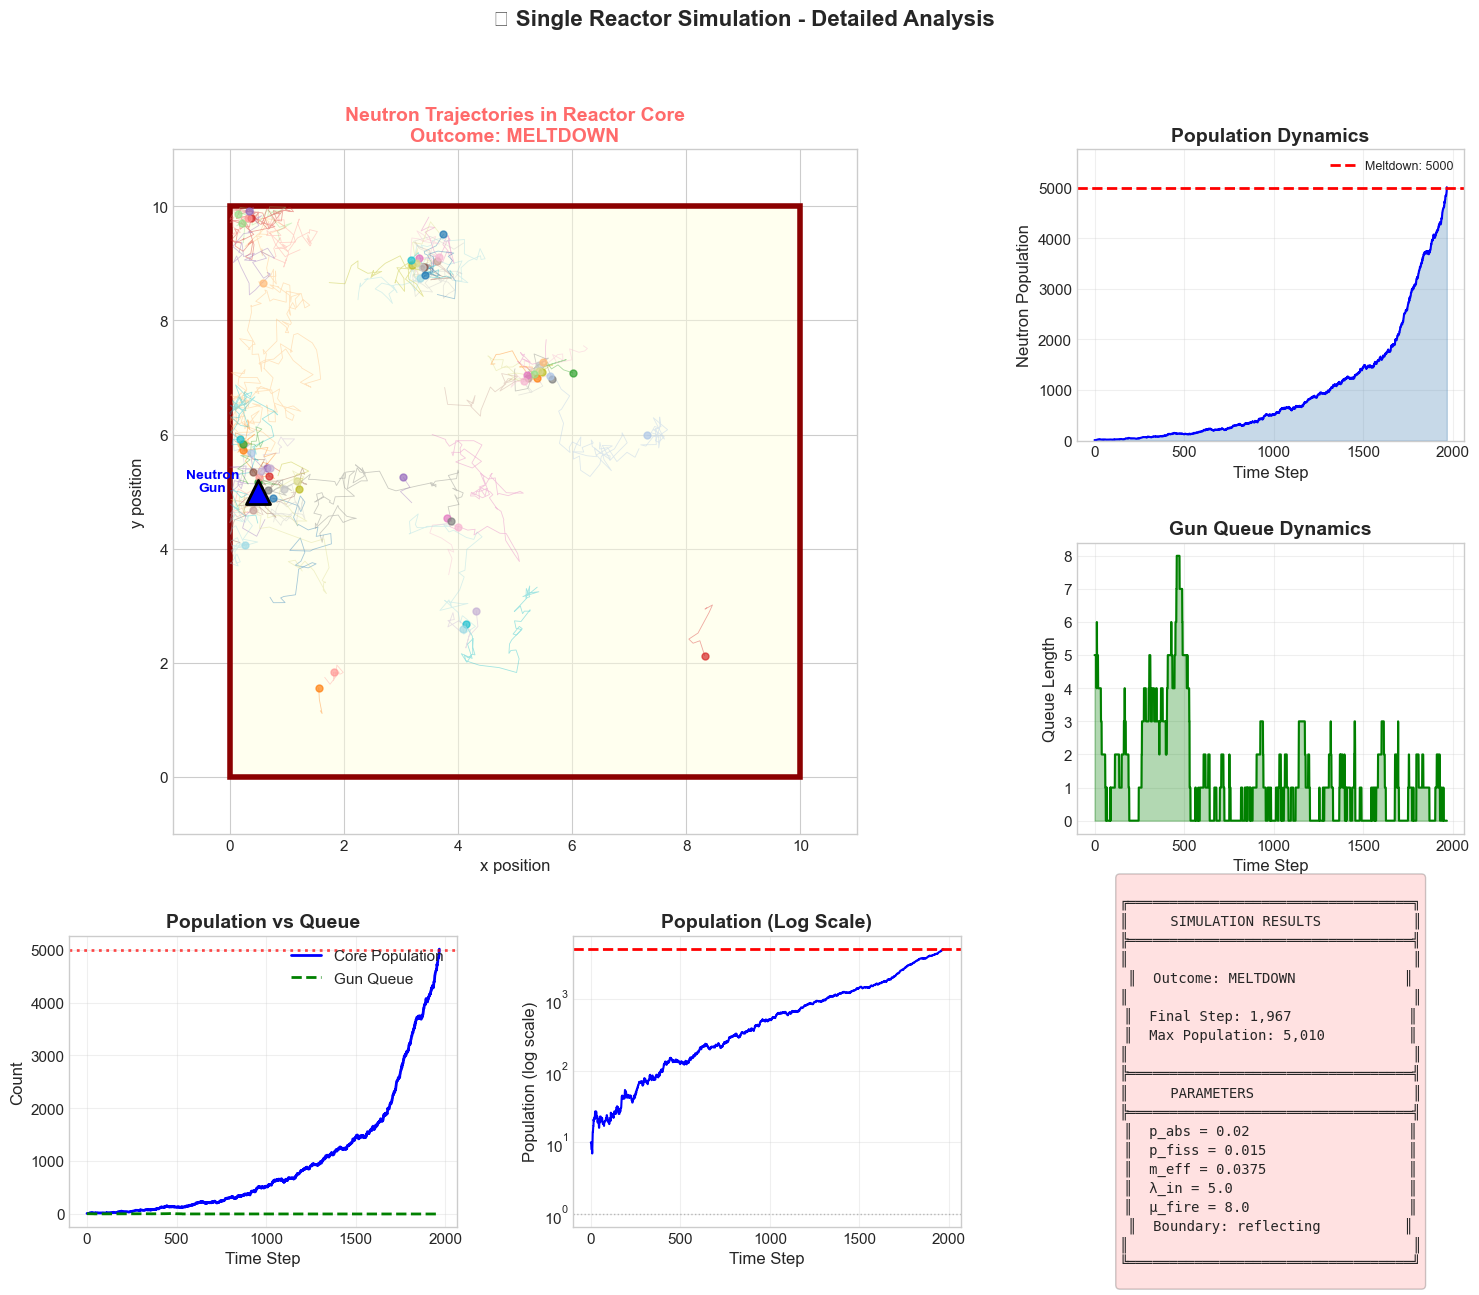

In [ ]:
def plot_single_simulation(result: SimulationResult, params: SimulationParams):
    """
    Comprehensive visualization of a single simulation run.
    """
    fig = plt.figure(figsize=(18, 14))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

    # Color based on outcome
    outcome_colors = {
        Outcome.MELTDOWN: '#ff6b6b',
        Outcome.SHUTDOWN: '#4ecdc4',
        Outcome.CRITICAL: '#45b7d1'
    }
    outcome_color = outcome_colors[result.outcome]

    # === Panel 1 (Large): Neutron trajectories in 2D ===
    ax1 = fig.add_subplot(gs[0:2, 0:2])

    # Reactor core background
    rect_bg = Rectangle((0, 0), params.L, params.L,
                        facecolor='lightyellow', alpha=0.5)
    ax1.add_patch(rect_bg)

    if result.neutron_paths:
        n_paths = len(result.neutron_paths)
        colors = plt.cm.tab20(np.linspace(0, 1, min(n_paths, 20)))

        for i, (hx, hy) in enumerate(result.neutron_paths[:60]):
            color = colors[i % len(colors)]
            ax1.plot(hx, hy, alpha=0.4, linewidth=0.6, color=color)
            ax1.scatter(hx[0], hy[0], color=color, s=25, marker='o',
                       alpha=0.7, zorder=4)

    # Reactor boundary
    rect = Rectangle((0, 0), params.L, params.L, fill=False,
                     edgecolor='darkred', linewidth=4)
    ax1.add_patch(rect)

    # Entry point (neutron gun)
    ex, ey = params.entry_point
    ax1.scatter(ex, ey, color='blue', s=300, marker='^',
               edgecolor='black', linewidth=2, zorder=10)
    ax1.annotate('Neutron\nGun', xy=(ex - 0.8, ey), fontsize=10,
                ha='center', fontweight='bold', color='blue')

    ax1.set_xlim(-1, params.L + 1)
    ax1.set_ylim(-1, params.L + 1)
    ax1.set_xlabel('x position', fontsize=12)
    ax1.set_ylabel('y position', fontsize=12)
    ax1.set_title(f'Neutron Trajectories in Reactor Core\n'
                 f'Outcome: {result.outcome.value.upper()}',
                 fontsize=14, fontweight='bold', color=outcome_color)
    ax1.set_aspect('equal')

    # === Panel 2: Population over time ===
    ax2 = fig.add_subplot(gs[0, 2])

    steps = np.arange(len(result.population_history))
    ax2.fill_between(steps, result.population_history, alpha=0.3, color='steelblue')
    ax2.plot(steps, result.population_history, 'b-', linewidth=1.5)
    ax2.axhline(y=params.N_max, color='red', linestyle='--',
               linewidth=2, label=f'Meltdown: {params.N_max}')

    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Neutron Population')
    ax2.set_title('Population Dynamics', fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.set_ylim(0, max(result.max_population * 1.15, params.N_max * 0.3))
    ax2.grid(True, alpha=0.3)

    # === Panel 3: Queue dynamics ===
    ax3 = fig.add_subplot(gs[1, 2])

    ax3.fill_between(steps, result.queue_history, alpha=0.3, color='green')
    ax3.plot(steps, result.queue_history, 'g-', linewidth=1.5)

    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Queue Length')
    ax3.set_title('Gun Queue Dynamics', fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # === Panel 4: Combined view ===
    ax4 = fig.add_subplot(gs[2, 0])

    ax4.plot(steps, result.population_history, 'b-',
            label='Core Population', linewidth=2)
    ax4.plot(steps, result.queue_history, 'g--',
            label='Gun Queue', linewidth=2)
    ax4.axhline(y=params.N_max, color='red', linestyle=':',
               alpha=0.7, linewidth=2)

    ax4.set_xlabel('Time Step')
    ax4.set_ylabel('Count')
    ax4.set_title('Population vs Queue', fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    # === Panel 5: Log-scale population ===
    ax5 = fig.add_subplot(gs[2, 1])

    pop_array = np.array(result.population_history, dtype=float)
    pop_array[pop_array == 0] = 0.5
    ax5.semilogy(steps, pop_array, 'b-', linewidth=1.5)
    ax5.axhline(y=params.N_max, color='red', linestyle='--', linewidth=2)
    ax5.axhline(y=1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

    ax5.set_xlabel('Time Step')
    ax5.set_ylabel('Population (log scale)')
    ax5.set_title('Population (Log Scale)', fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # === Panel 6: Statistics summary ===
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis('off')

    stats_text = f"""
╔══════════════════════════════════╗
║     SIMULATION RESULTS           ║
╠══════════════════════════════════╣
║                                  ║
║  Outcome: {result.outcome.value.upper():<20} ║
║                                  ║
║  Final Step: {result.final_step:<18,} ║
║  Max Population: {result.max_population:<14,} ║
║                                  ║
╠══════════════════════════════════╣
║     PARAMETERS                   ║
╠══════════════════════════════════╣
║  p_abs = {params.p_abs:<22} ║
║  p_fiss = {params.p_fiss:<21} ║
║  m_eff = {params.m_eff:<22.4f} ║
║  λ_in = {params.lambda_in:<23} ║
║  μ_fire = {params.mu_fire:<21} ║
║  Boundary: {params.boundary:<19} ║
║                                  ║
╚══════════════════════════════════╝
"""

    ax6.text(0.5, 0.5, stats_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor=outcome_color, alpha=0.2))

    plt.suptitle('📊 Single Reactor Simulation - Detailed Analysis',
                fontsize=16, fontweight='bold', y=0.98)
    plt.savefig('03_single_simulation.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_single_simulation(result, params)

---
## 10. 📈 Monte Carlo Estimation

Run many simulations to estimate outcome probabilities with confidence intervals.

In [ ]:
# Run Monte Carlo simulation
M = 10  # Number of runs

print(f"Running {M} Monte Carlo simulations...")
print("="*50)

np.random.seed(42)
mc_results = sim.run_monte_carlo(M=M, verbose=True)

print("\n" + "="*50)
print("MONTE CARLO RESULTS")
print("="*50)

for outcome in ['meltdown', 'shutdown', 'critical']:
    r = mc_results[outcome]
    print(f"\n{outcome.upper()}:")
    print(f"  Count: {r['count']:,} */* {M:,}")
    print(f"  Probability: {r['probability']:.4f}")
    print(f"  Standard Error: {r['std_error']:.4f}")
    print(f"  95% CI: [{r['ci_95'][0]:.4f}, {r['ci_95'][1]:.4f}]")

print(f"\nPopulation Statistics:")
print(f"  Mean max population: {mc_results['max_population']['mean']:.1f}")
print(f"  Std: {mc_results['max_population']['std']:.1f}")
print(f"  Median: {mc_results['max_population']['median']:.1f}")

Running 10 Monte Carlo simulations...

MONTE CARLO RESULTS

MELTDOWN:
  Count: 10 */* 10
  Probability: 1.0000
  Standard Error: 0.0000
  95% CI: [0.7225, 1.0000]

SHUTDOWN:
  Count: 0 */* 10
  Probability: 0.0000
  Standard Error: 0.0000
  95% CI: [0.0000, 0.2775]

CRITICAL:
  Count: 0 */* 10
  Probability: 0.0000
  Standard Error: 0.0000
  95% CI: [0.0000, 0.2775]

Population Statistics:
  Mean max population: 5016.1
  Std: 5.4
  Median: 5016.5


[array([0.2775328]), array([1.11022302e-16])]
[array([0.]), array([0.2775328])]
[array([0.]), array([0.2775328])]


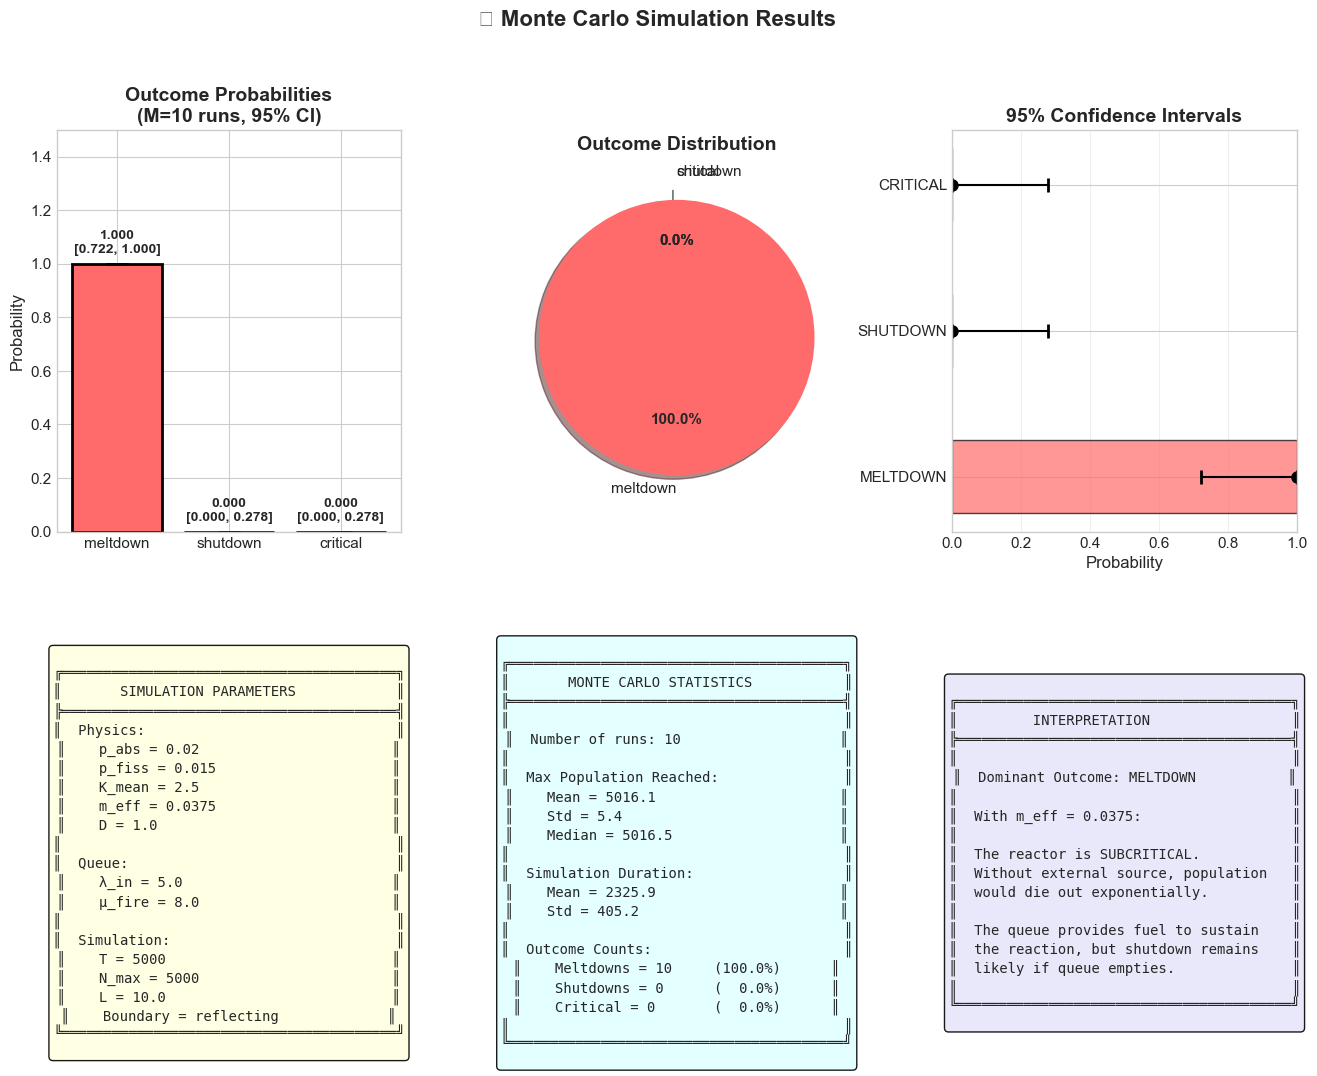

In [ ]:
def plot_monte_carlo_results(results: Dict, params: SimulationParams):
    """
    Visualize Monte Carlo estimation results.
    """
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

    outcomes = ['meltdown', 'shutdown', 'critical']
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

    # === Panel 1: Bar chart with error bars ===
    ax1 = fig.add_subplot(gs[0, 0])

    probs = [results[o]['probability'] for o in outcomes]
    errors = [results[o]['std_error'] * 1.96 for o in outcomes]

    bars = ax1.bar(outcomes, probs, color=colors, edgecolor='black', linewidth=2)
    ax1.errorbar(outcomes, probs, yerr=errors, fmt='none', color='black',
                capsize=8, capthick=2, linewidth=2)

    for bar, p, o in zip(bars, probs, outcomes):
        ci = results[o]['ci_95']
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                f'{p:.3f}\n[{ci[0]:.3f}, {ci[1]:.3f}]',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax1.set_ylabel('Probability', fontsize=12)
    ax1.set_title(f'Outcome Probabilities\n(M={results["M"]:,} runs, 95% CI)', fontweight='bold')
    ax1.set_ylim(0, max(probs) * 1.4 + 0.1)

    # === Panel 2: Pie chart ===
    ax2 = fig.add_subplot(gs[0, 1])

    counts = [results[o]['count'] for o in outcomes]
    explode = (0.05, 0.05, 0.05)

    wedges, texts, autotexts = ax2.pie(counts, explode=explode, labels=outcomes,
                                        colors=colors, autopct='%1.1f%%',
                                        shadow=True, startangle=90,
                                        textprops={'fontsize': 11})
    for autotext in autotexts:
        autotext.set_fontweight('bold')

    ax2.set_title('Outcome Distribution', fontweight='bold')

    # === Panel 3: Confidence interval visualization ===
    ax3 = fig.add_subplot(gs[0, 2])

    y_pos = np.arange(len(outcomes))

    for i, (outcome, color) in enumerate(zip(outcomes, colors)):
        p = results[outcome]['probability']
        ci = results[outcome]['ci_95']
        x_errs = [np.abs([p - ci[0]]), np.abs([ci[1] - p])]
        # x_errs = [([p - ci[0]]), ([ci[1] - p])]
        # x_errs = [np.round([p - ci[0]], 15), np.round([ci[1] - p], 15)]

        print(x_errs)


        ax3.barh(i, p, color=color, edgecolor='black', height=0.5, alpha=0.7)
        ax3.errorbar(p, i, xerr=x_errs,
                    fmt='o', color='black', capsize=5, capthick=2, markersize=8)

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([o.upper() for o in outcomes])
    ax3.set_xlabel('Probability')
    ax3.set_title('95% Confidence Intervals', fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.grid(True, alpha=0.3, axis='x')

    # === Panel 4: Parameter summary ===
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')

    param_text = f"""
╔════════════════════════════════════════╗
║       SIMULATION PARAMETERS            ║
╠════════════════════════════════════════╣
║  Physics:                              ║
║    p_abs = {params.p_abs:<26} ║
║    p_fiss = {params.p_fiss:<25} ║
║    K_mean = {params.K_mean:<25} ║
║    m_eff = {params.m_eff:<26.4f} ║
║    D = {params.D:<30} ║
║                                        ║
║  Queue:                                ║
║    λ_in = {params.lambda_in:<27} ║
║    μ_fire = {params.mu_fire:<25} ║
║                                        ║
║  Simulation:                           ║
║    T = {params.T:<30} ║
║    N_max = {params.N_max:<26} ║
║    L = {params.L:<30} ║
║    Boundary = {params.boundary:<22} ║
╚════════════════════════════════════════╝
"""
    ax4.text(0.5, 0.5, param_text, transform=ax4.transAxes,
            fontsize=10, verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

    # === Panel 5: Statistics summary ===
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.axis('off')

    stats_text = f"""
╔════════════════════════════════════════╗
║       MONTE CARLO STATISTICS           ║
╠════════════════════════════════════════╣
║                                        ║
║  Number of runs: {results['M']:<20,} ║
║                                        ║
║  Max Population Reached:               ║
║    Mean = {results['max_population']['mean']:<27.1f} ║
║    Std = {results['max_population']['std']:<28.1f} ║
║    Median = {results['max_population']['median']:<25.1f} ║
║                                        ║
║  Simulation Duration:                  ║
║    Mean = {results['final_step']['mean']:<27.1f} ║
║    Std = {results['final_step']['std']:<28.1f} ║
║                                        ║
║  Outcome Counts:                       ║
║    Meltdowns = {results['meltdown']['count']:<6} ({results['meltdown']['probability']*100:5.1f}%)      ║
║    Shutdowns = {results['shutdown']['count']:<6} ({results['shutdown']['probability']*100:5.1f}%)      ║
║    Critical = {results['critical']['count']:<7} ({results['critical']['probability']*100:5.1f}%)      ║
║                                        ║
╚════════════════════════════════════════╝
"""
    ax5.text(0.5, 0.5, stats_text, transform=ax5.transAxes,
            fontsize=10, verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))

    # === Panel 6: Interpretation ===
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')

    # Determine dominant outcome
    dominant = max(outcomes, key=lambda o: results[o]['probability'])

    interp_text = f"""
╔════════════════════════════════════════╗
║         INTERPRETATION                 ║
╠════════════════════════════════════════╣
║                                        ║
║  Dominant Outcome: {dominant.upper():<18} ║
║                                        ║
║  With m_eff = {params.m_eff:.4f}:                  ║
║                                        ║"""

    if params.m_eff < 1:
        interp_text += """
║  The reactor is SUBCRITICAL.           ║
║  Without external source, population   ║
║  would die out exponentially.          ║
║                                        ║
║  The queue provides fuel to sustain    ║
║  the reaction, but shutdown remains    ║
║  likely if queue empties.              ║"""
    elif params.m_eff > 1:
        interp_text += """
║  The reactor is SUPERCRITICAL.         ║
║  Population growth outpaces losses.    ║
║  Meltdown is increasingly likely       ║
║  without control interventions.        ║"""
    else:
        interp_text += """
║  The reactor is near CRITICAL.         ║
║  Balance between growth and losses.    ║
║  Outcome depends sensitively on        ║
║  random fluctuations.                  ║"""

    interp_text += """
║                                        ║
╚════════════════════════════════════════╝
"""
    ax6.text(0.5, 0.5, interp_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='center', horizontalalignment='center',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.9))

    plt.suptitle('📊 Monte Carlo Simulation Results', fontsize=16, fontweight='bold')
    plt.savefig('04_monte_carlo_results.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_monte_carlo_results(mc_results, params)

---
## 11. 📈 Ensemble Trajectories

Visualize the variability across multiple simulation runs.

Running 8 simulations for ensemble plot...


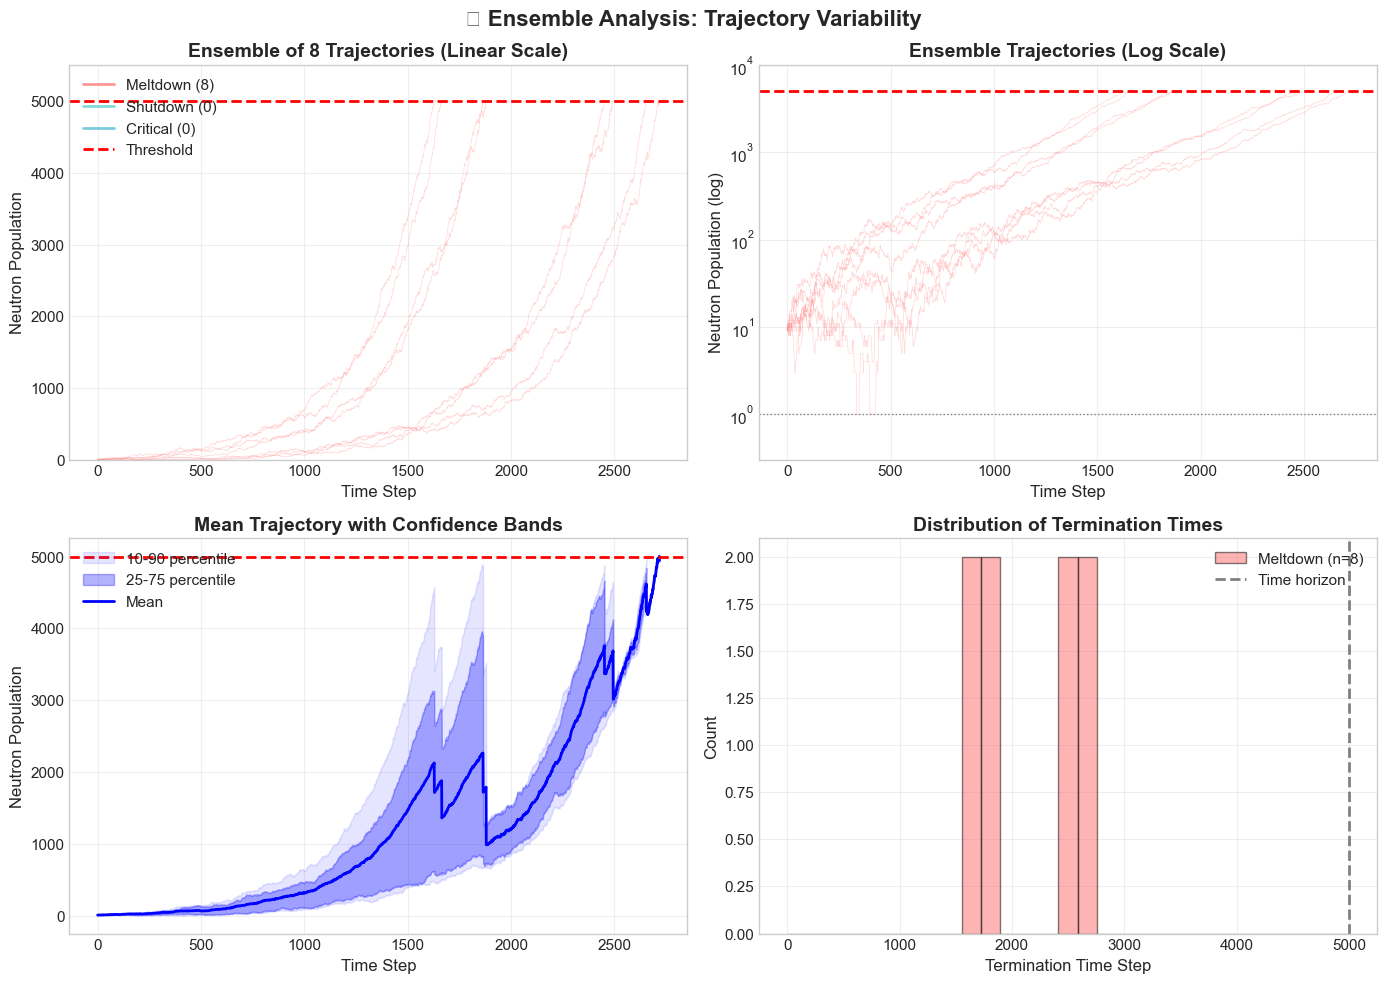

In [ ]:
def plot_ensemble_trajectories(params: SimulationParams, n_runs: int = 100):
    """
    Plot population trajectories from multiple runs to show variability.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    sim = ReactorSimulator(params)
    np.random.seed(123)

    all_pops = []
    outcomes_dict = {'meltdown': [], 'shutdown': [], 'critical': []}

    print(f"Running {n_runs} simulations for ensemble plot...")

    for i in range(n_runs):
        if (i + 1) % 25 == 0:
            print(f"  Progress: {i + 1}/{n_runs}")
        result = sim.run_single(track_paths=False)
        all_pops.append(result.population_history)
        outcomes_dict[result.outcome.value].append(result.population_history)

    colors = {'meltdown': '#ff6b6b', 'shutdown': '#4ecdc4', 'critical': '#45b7d1'}

    # === Panel 1: All trajectories colored by outcome ===
    ax1 = axes[0, 0]

    for outcome, pops in outcomes_dict.items():
        for pop in pops:
            ax1.plot(pop, color=colors[outcome], alpha=0.25, linewidth=0.5)

    ax1.axhline(y=params.N_max, color='red', linestyle='--', linewidth=2)

    legend_elements = [
        Line2D([0], [0], color='#ff6b6b', label=f'Meltdown ({len(outcomes_dict["meltdown"])})', alpha=0.7, linewidth=2),
        Line2D([0], [0], color='#4ecdc4', label=f'Shutdown ({len(outcomes_dict["shutdown"])})', alpha=0.7, linewidth=2),
        Line2D([0], [0], color='#45b7d1', label=f'Critical ({len(outcomes_dict["critical"])})', alpha=0.7, linewidth=2),
        Line2D([0], [0], color='red', linestyle='--', label='Threshold', linewidth=2)
    ]
    ax1.legend(handles=legend_elements, loc='upper left')

    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Neutron Population')
    ax1.set_title(f'Ensemble of {n_runs} Trajectories (Linear Scale)', fontweight='bold')
    ax1.set_ylim(0, params.N_max * 1.1)
    ax1.grid(True, alpha=0.3)

    # === Panel 2: Log scale ===
    ax2 = axes[0, 1]

    for outcome, pops in outcomes_dict.items():
        for pop in pops:
            pop_arr = np.array(pop, dtype=float)
            pop_arr[pop_arr == 0] = 0.5
            ax2.semilogy(pop_arr, color=colors[outcome], alpha=0.25, linewidth=0.5)

    ax2.axhline(y=params.N_max, color='red', linestyle='--', linewidth=2)
    ax2.axhline(y=1, color='gray', linestyle=':', linewidth=1)

    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Neutron Population (log)')
    ax2.set_title('Ensemble Trajectories (Log Scale)', fontweight='bold')
    ax2.set_ylim(0.3, params.N_max * 2)
    ax2.grid(True, alpha=0.3)

    # === Panel 3: Mean with confidence bands ===
    ax3 = axes[1, 0]

    max_len = max(len(p) for p in all_pops)
    padded = np.full((n_runs, max_len), np.nan)
    for i, pop in enumerate(all_pops):
        padded[i, :len(pop)] = pop

    mean_pop = np.nanmean(padded, axis=0)
    percentile_10 = np.nanpercentile(padded, 10, axis=0)
    percentile_90 = np.nanpercentile(padded, 90, axis=0)
    percentile_25 = np.nanpercentile(padded, 25, axis=0)
    percentile_75 = np.nanpercentile(padded, 75, axis=0)

    steps = np.arange(max_len)

    ax3.fill_between(steps, percentile_10, percentile_90,
                    color='blue', alpha=0.1, label='10-90 percentile')
    ax3.fill_between(steps, percentile_25, percentile_75,
                    color='blue', alpha=0.3, label='25-75 percentile')
    ax3.plot(steps, mean_pop, 'b-', linewidth=2, label='Mean')
    ax3.axhline(y=params.N_max, color='red', linestyle='--', linewidth=2)

    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Neutron Population')
    ax3.set_title('Mean Trajectory with Confidence Bands', fontweight='bold')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)

    # === Panel 4: Outcome timing histogram ===
    ax4 = axes[1, 1]

    meltdown_times = [len(p) for p in outcomes_dict['meltdown']]
    shutdown_times = [len(p) for p in outcomes_dict['shutdown']]
    critical_times = [len(p) for p in outcomes_dict['critical']]

    bins = np.linspace(0, params.T, 30)

    if meltdown_times:
        ax4.hist(meltdown_times, bins=bins, alpha=0.5, color='#ff6b6b',
                label=f'Meltdown (n={len(meltdown_times)})', edgecolor='black')
    if shutdown_times:
        ax4.hist(shutdown_times, bins=bins, alpha=0.5, color='#4ecdc4',
                label=f'Shutdown (n={len(shutdown_times)})', edgecolor='black')

    ax4.axvline(x=params.T, color='gray', linestyle='--', linewidth=2, label='Time horizon')

    ax4.set_xlabel('Termination Time Step')
    ax4.set_ylabel('Count')
    ax4.set_title('Distribution of Termination Times', fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    plt.suptitle('🔄 Ensemble Analysis: Trajectory Variability', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('05_ensemble_trajectories.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_ensemble_trajectories(params, n_runs=8)

---
## 12. 📊 Parameter Sweep: Fission Probability

Investigate how varying `p_fiss` affects outcome probabilities.

In [ ]:
def parameter_sweep(param_name: str, param_values: np.ndarray,
                    base_params: SimulationParams, M: int = 300):
    """
    Sweep a parameter and compute outcome probabilities.
    """
    n_vals = len(param_values)

    probs = {'meltdown': [], 'shutdown': [], 'critical': []}
    cis = {'meltdown': [], 'shutdown': [], 'critical': []}
    m_eff_values = []

    print(f"Parameter sweep: {param_name}")
    print("="*50)

    for i, val in enumerate(param_values):
        print(f"  {param_name} = {val:.4f} ({i+1}/{n_vals})")

        # Create modified params
        params_dict = {
            'L': base_params.L, 'D': base_params.D, 'dt': base_params.dt,
            'p_abs': base_params.p_abs, 'p_fiss': base_params.p_fiss,
            'K_mean': base_params.K_mean, 'lambda_in': base_params.lambda_in,
            'mu_fire': base_params.mu_fire, 'T': base_params.T,
            'N_max': base_params.N_max, 'N_init': base_params.N_init,
            'Q_init': base_params.Q_init, 'boundary': base_params.boundary
        }
        params_dict[param_name] = val
        sweep_params = SimulationParams(**params_dict)

        m_eff_values.append(sweep_params.m_eff)

        sim = ReactorSimulator(sweep_params)
        results = sim.run_monte_carlo(M=M, verbose=False)

        for outcome in ['meltdown', 'shutdown', 'critical']:
            probs[outcome].append(results[outcome]['probability'])
            cis[outcome].append(results[outcome]['ci_95'])

    return probs, cis, m_eff_values


# Sweep p_fiss
p_fiss_values = np.linspace(0.005, 0.035, 5)
probs_pfiss, cis_pfiss, m_eff_pfiss = parameter_sweep('p_fiss', p_fiss_values, params, M=100)

Parameter sweep: p_fiss
  p_fiss = 0.0050 (1/5)
  p_fiss = 0.0125 (2/5)


KeyboardInterrupt: 

In [ ]:
np.random.seed(0)

base_params = params  # your existing SimulationParams with default p_fiss, p_abs

sa2_result = sa_optimize_fiss_abs(
    base_params,
    p_fiss_init=base_params.p_fiss,
    p_abs_init=base_params.p_abs,
    M_eval=15,          # very small for speed; noisy but fine for tweaking
    max_iters=20,
    T0=0.3,
    alpha=0.9,
    step_fiss=0.0005,
    step_abs=0.0005,
    bounds_fiss=(0.0, 0.05),
    bounds_abs=(0.0, 0.10)
)

print("\nApproximate 'good' pair:")
print("  p_fiss* =", sa2_result["best_p_fiss"])
print("  p_abs*  =", sa2_result["best_p_abs"])
print("  J*      ≈", sa2_result["best_cost"])


NameError: name 'np' is not defined

In [ ]:


def plot_sa_history(history):
    iters = [h["iter"] for h in history]
    cur_pf = [h["cur_pf"] for h in history]
    cur_pa = [h["cur_pa"] for h in history]
    cur_J  = [h["cur_cost"] for h in history]
    best_J = [h["best_cost"] for h in history]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # p_fiss over iterations
    axes[0].plot(iters, cur_pf, marker="o")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("p_fiss")
    axes[0].set_title("Simulated annealing: p_fiss")

    # p_abs over iterations
    axes[1].plot(iters, cur_pa, marker="o")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("p_abs")
    axes[1].set_title("Simulated annealing: p_abs")

    # cost over iterations
    axes[2].plot(iters, cur_J, marker="o", label="Current J")
    axes[2].plot(iters, best_J, linestyle="--", label="Best J so far")
    axes[2].set_xlabel("Iteration")
    axes[2].set_ylabel("Cost J")
    axes[2].set_title("Simulated annealing: objective")
    axes[2].legend()

    fig.suptitle("Simulated annealing optimisation of (p_fiss, p_abs)", y=1.05)
    plt.tight_layout()
    plt.show()


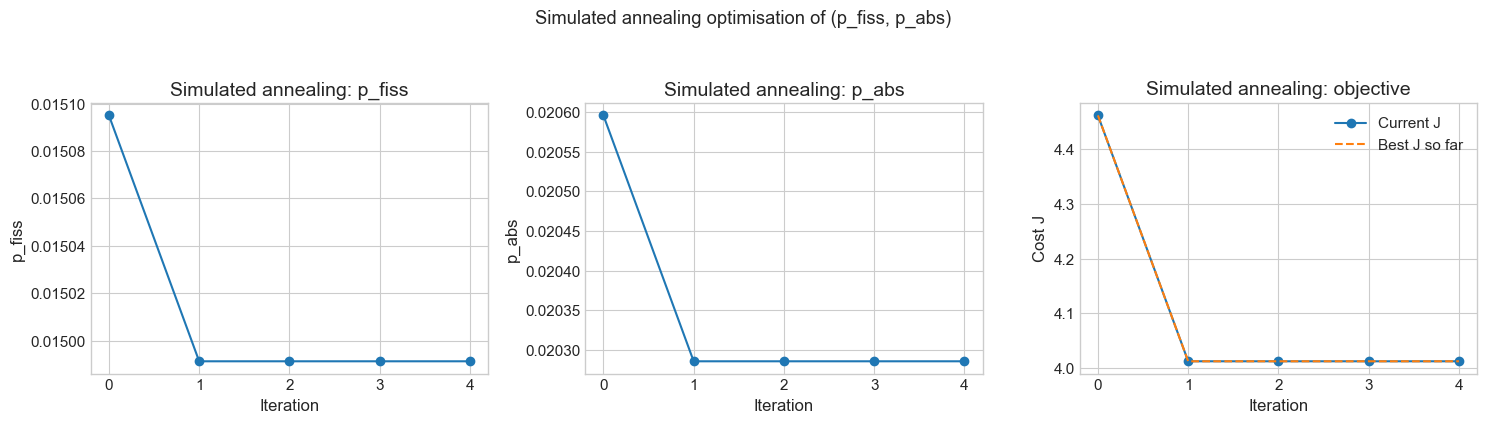

In [ ]:
plot_sa_history(sa2_result["history"])


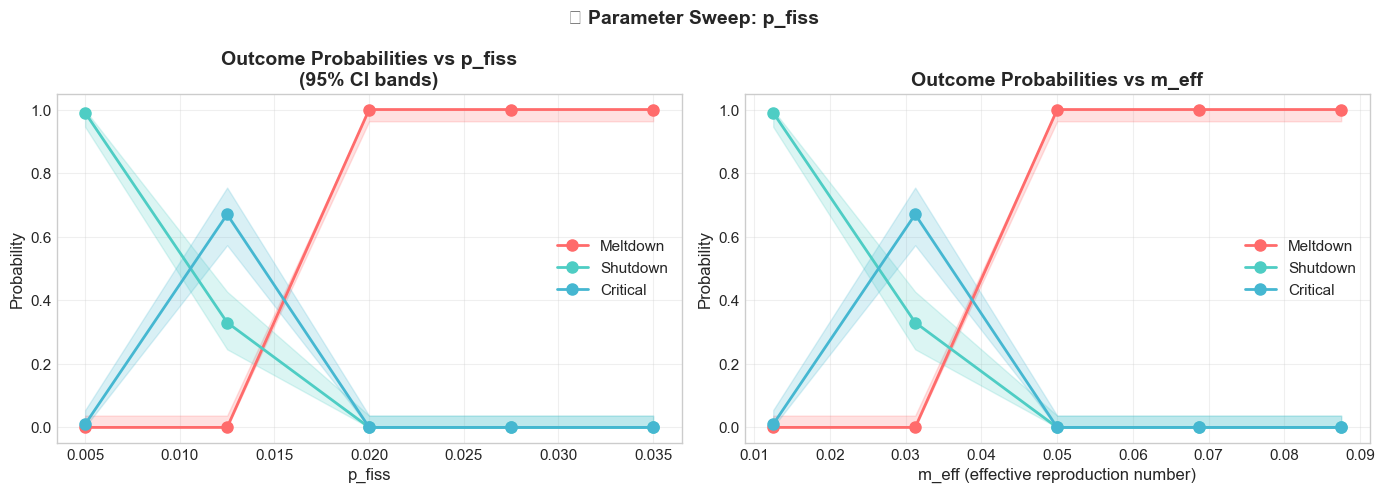

In [ ]:
def plot_parameter_sweep(param_values, probs, cis, m_eff_values, param_name):
    """
    Plot parameter sweep results.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    colors = {'meltdown': '#ff6b6b', 'shutdown': '#4ecdc4', 'critical': '#45b7d1'}

    # Convert CIs to arrays
    for outcome in ['meltdown', 'shutdown', 'critical']:
        cis[outcome] = np.array(cis[outcome])

    # === Panel 1: vs parameter value ===
    ax1 = axes[0]

    for outcome in ['meltdown', 'shutdown', 'critical']:
        p = np.array(probs[outcome])
        ci = cis[outcome]

        ax1.plot(param_values, p, 'o-', color=colors[outcome],
                label=outcome.capitalize(), linewidth=2, markersize=8)
        ax1.fill_between(param_values, ci[:, 0], ci[:, 1],
                        color=colors[outcome], alpha=0.2)

    ax1.set_xlabel(param_name, fontsize=12)
    ax1.set_ylabel('Probability', fontsize=12)
    ax1.set_title(f'Outcome Probabilities vs {param_name}\n(95% CI bands)', fontweight='bold')
    ax1.legend(loc='best')
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, alpha=0.3)

    # === Panel 2: vs m_eff ===
    ax2 = axes[1]

    for outcome in ['meltdown', 'shutdown', 'critical']:
        p = np.array(probs[outcome])
        ci = cis[outcome]

        ax2.plot(m_eff_values, p, 'o-', color=colors[outcome],
                label=outcome.capitalize(), linewidth=2, markersize=8)
        ax2.fill_between(m_eff_values, ci[:, 0], ci[:, 1],
                        color=colors[outcome], alpha=0.2)

    # Critical line at m_eff = 1
    if max(m_eff_values) >= 1:
        ax2.axvline(x=1.0, color='gray', linestyle='--', linewidth=2,
                   label='Critical (m_eff=1)')

    ax2.set_xlabel('m_eff (effective reproduction number)', fontsize=12)
    ax2.set_ylabel('Probability', fontsize=12)
    ax2.set_title('Outcome Probabilities vs m_eff', fontweight='bold')
    ax2.legend(loc='best')
    ax2.set_ylim(-0.05, 1.05)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'📈 Parameter Sweep: {param_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'06_sweep_{param_name}.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_parameter_sweep(p_fiss_values, probs_pfiss, cis_pfiss, m_eff_pfiss, 'p_fiss')

---
## 13. 📊 Parameter Sweep: Arrival Rate (λ_in)

In [ ]:
# Sweep lambda_in
lambda_values = np.linspace(1, 20, 8)
probs_lambda, cis_lambda, m_eff_lambda = parameter_sweep('lambda_in', lambda_values, params, M=20)

Parameter sweep: lambda_in
  lambda_in = 1.0000 (1/8)
  lambda_in = 3.7143 (2/8)
  lambda_in = 6.4286 (3/8)
  lambda_in = 9.1429 (4/8)
  lambda_in = 11.8571 (5/8)
  lambda_in = 14.5714 (6/8)
  lambda_in = 17.2857 (7/8)
  lambda_in = 20.0000 (8/8)


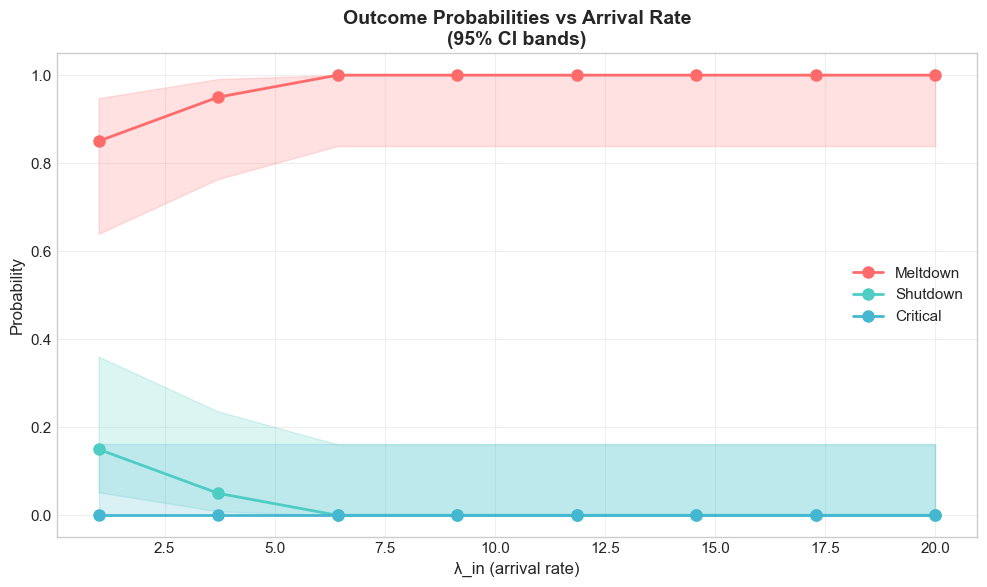

In [ ]:
def plot_lambda_sweep(lambda_values, probs, cis):
    """
    Plot lambda_in sweep results.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = {'meltdown': '#ff6b6b', 'shutdown': '#4ecdc4', 'critical': '#45b7d1'}

    for outcome in ['meltdown', 'shutdown', 'critical']:
        p = np.array(probs[outcome])
        ci = np.array(cis[outcome])

        ax.plot(lambda_values, p, 'o-', color=colors[outcome],
               label=outcome.capitalize(), linewidth=2, markersize=8)
        ax.fill_between(lambda_values, ci[:, 0], ci[:, 1],
                       color=colors[outcome], alpha=0.2)

    ax.set_xlabel('λ_in (arrival rate)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title('Outcome Probabilities vs Arrival Rate\n(95% CI bands)', fontweight='bold')
    ax.legend(loc='best')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('07_sweep_lambda.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_lambda_sweep(lambda_values, probs_lambda, cis_lambda)

---
## 14. 🧪 Hypothesis Testing: Compare Two Configurations

In [ ]:
# Define two configurations
config_A = SimulationParams(
    L=10.0, D=1.0, dt=0.01,
    p_abs=0.02, p_fiss=0.010, K_mean=2.5,  # Low fission
    lambda_in=5.0, mu_fire=8.0,
    T=5000, N_max=5000, N_init=10, Q_init=5,
    boundary='reflecting'
)

config_B = SimulationParams(
    L=10.0, D=1.0, dt=0.01,
    p_abs=0.02, p_fiss=0.025, K_mean=2.5,  # High fission
    lambda_in=5.0, mu_fire=8.0,
    T=5000, N_max=5000, N_init=10, Q_init=5,
    boundary='reflecting'
)

print("Configuration A (Low Fission):")
print(f"  p_fiss = {config_A.p_fiss}, m_eff = {config_A.m_eff:.4f}")
print(f"\nConfiguration B (High Fission):")
print(f"  p_fiss = {config_B.p_fiss}, m_eff = {config_B.m_eff:.4f}")

Configuration A (Low Fission):
  p_fiss = 0.01, m_eff = 0.0250

Configuration B (High Fission):
  p_fiss = 0.025, m_eff = 0.0625


In [ ]:
# Run simulations for both configurations
M_test = 10

print(f"\nRunning {M_test} simulations for Configuration A...")
sim_A = ReactorSimulator(config_A)
np.random.seed(42)
results_A = sim_A.run_monte_carlo(M=M_test, verbose=True)

print(f"\nRunning {M_test} simulations for Configuration B...")
sim_B = ReactorSimulator(config_B)
np.random.seed(43)
results_B = sim_B.run_monte_carlo(M=M_test, verbose=True)


Running 10 simulations for Configuration A...

Running 10 simulations for Configuration B...


In [ ]:
# Perform hypothesis tests
print("\n" + "="*60)
print("HYPOTHESIS TESTING RESULTS")
print("="*60)
print("\nH₀: P_A = P_B  vs  H₁: P_A ≠ P_B")
print("-"*60)

test_results = {}
for outcome in ['meltdown', 'shutdown', 'critical']:
    n1, x1 = M_test, results_A[outcome]['count']
    n2, x2 = M_test, results_B[outcome]['count']

    test = two_sample_proportion_test(n1, x1, n2, x2)
    test_results[outcome] = test

    print_hypothesis_test(test, outcome.upper())


HYPOTHESIS TESTING RESULTS

H₀: P_A = P_B  vs  H₁: P_A ≠ P_B
------------------------------------------------------------

  MELTDOWN:
    p̂₁ = 0.0000
    p̂₂ = 1.0000
    Difference = -1.0000
    Z-statistic = -4.4721
    p-value = 0.000008
    Significant at α=0.05? ✓ YES
    Significant at α=0.01? ✓ YES

  SHUTDOWN:
    p̂₁ = 0.7000
    p̂₂ = 0.0000
    Difference = 0.7000
    Z-statistic = 3.2817
    p-value = 0.001032
    Significant at α=0.05? ✓ YES
    Significant at α=0.01? ✓ YES

  CRITICAL:
    p̂₁ = 0.3000
    p̂₂ = 0.0000
    Difference = 0.3000
    Z-statistic = 1.8787
    p-value = 0.060289
    Significant at α=0.05? ✗ NO
    Significant at α=0.01? ✗ NO


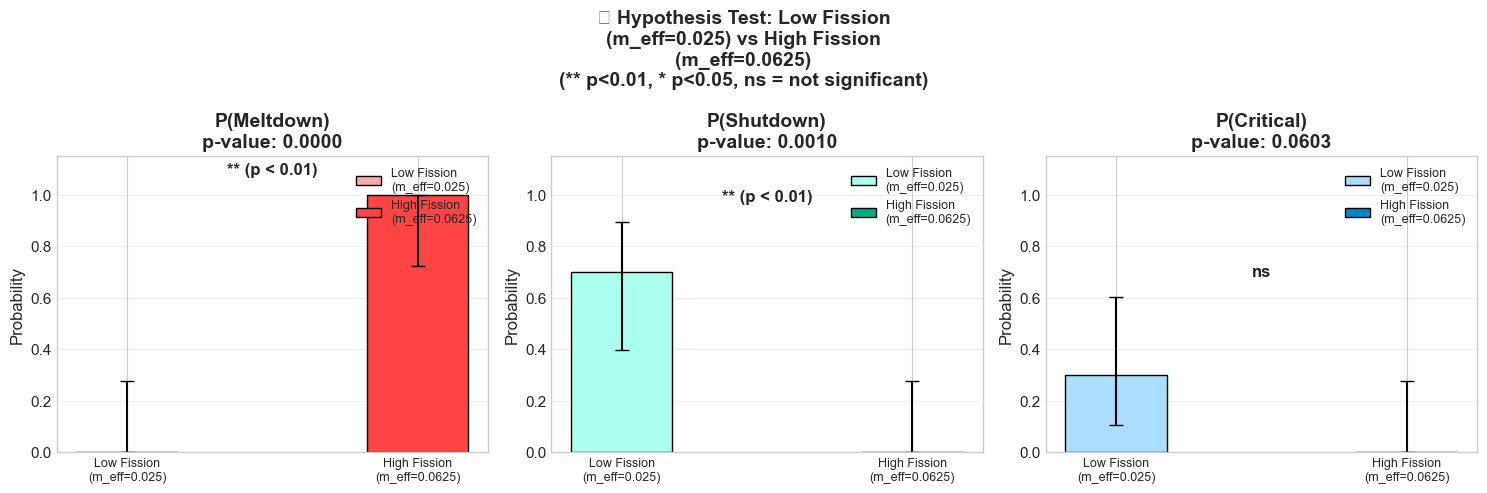

In [ ]:
def plot_hypothesis_test(results_A, results_B, test_results, M, labels):
    """
    Visualize hypothesis test comparison.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    outcomes = ['meltdown', 'shutdown', 'critical']
    colors_light = ['#ffaaaa', '#aaffee', '#aaddff']
    colors_dark = ['#ff4444', '#00aa88', '#0088cc']

    for idx, (ax, outcome) in enumerate(zip(axes, outcomes)):
        p_A = results_A[outcome]['probability']
        p_B = results_B[outcome]['probability']
        ci_A = results_A[outcome]['ci_95']
        ci_B = results_B[outcome]['ci_95']

        err_A = [np.abs([p_A - ci_A[0]]), np.abs([ci_A[1] - p_A])]
        err_B = [np.abs([p_B - ci_B[0]]), np.abs([ci_B[1] - p_B])]

        ax.bar(0, p_A, 0.35, color=colors_light[idx], edgecolor='black',
              label=labels[0], yerr=err_A, capsize=5)
        ax.bar(1, p_B, 0.35, color=colors_dark[idx], edgecolor='black',
              label=labels[1], yerr=err_B, capsize=5)

        # Significance annotation
        test = test_results[outcome]
        if test['significant_01']:
            sig_text = '** (p < 0.01)'
        elif test['significant_05']:
            sig_text = '* (p < 0.05)'
        else:
            sig_text = 'ns'

        y_max = max(ci_A[1], ci_B[1])
        ax.annotate(sig_text, xy=(0.5, y_max + 0.08),
                   ha='center', fontsize=12, fontweight='bold')

        ax.set_ylabel('Probability')
        ax.set_title(f'P({outcome.capitalize()})\np-value: {test["p_value"]:.4f}', fontweight='bold')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(labels, fontsize=9)
        ax.set_ylim(0, 1.15)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'🧪 Hypothesis Test: {labels[0]} vs {labels[1]}\n'
                f'(** p<0.01, * p<0.05, ns = not significant)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('08_hypothesis_test.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_hypothesis_test(
    results_A, results_B, test_results, M_test,
    labels=['Low Fission\n(m_eff=0.025)', 'High Fission\n(m_eff=0.0625)']
)

---
## 15. 🗺️ Phase Diagram

Generate a 2D phase diagram showing dominant regimes across parameter space.

In [ ]:
def generate_phase_diagram(p_fiss_range, lambda_range, base_params, M_per_point=150):
    """
    Generate phase diagram data.
    """
    n_p = len(p_fiss_range)
    n_l = len(lambda_range)

    P_meltdown = np.zeros((n_l, n_p))
    P_shutdown = np.zeros((n_l, n_p))
    P_critical = np.zeros((n_l, n_p))

    total = n_p * n_l
    current = 0

    print(f"Generating phase diagram: {n_p} × {n_l} = {total} points")
    print(f"Running {M_per_point} simulations per point...")
    print("="*50)

    for i, lambda_in in enumerate(lambda_range):
        for j, p_fiss in enumerate(p_fiss_range):
            current += 1
            if current % 5 == 0:
                print(f"  Progress: {current}/{total} ({100*current/total:.0f}%)")

            sweep_params = SimulationParams(
                L=base_params.L, D=base_params.D, dt=base_params.dt,
                p_abs=base_params.p_abs, p_fiss=p_fiss,
                K_mean=base_params.K_mean, lambda_in=lambda_in,
                mu_fire=base_params.mu_fire, T=base_params.T,
                N_max=base_params.N_max, N_init=base_params.N_init,
                Q_init=base_params.Q_init, boundary=base_params.boundary
            )

            sim = ReactorSimulator(sweep_params)
            results = sim.run_monte_carlo(M=M_per_point, verbose=False)

            P_meltdown[i, j] = results['meltdown']['probability']
            P_shutdown[i, j] = results['shutdown']['probability']
            P_critical[i, j] = results['critical']['probability']

    return P_meltdown, P_shutdown, P_critical


# Generate phase diagram
p_fiss_range = np.linspace(0.005, 0.035, 4)
lambda_range = np.linspace(1, 15, 4)

np.random.seed(42)
P_melt, P_shut, P_crit = generate_phase_diagram(p_fiss_range, lambda_range, params, M_per_point=15)

Generating phase diagram: 4 × 4 = 16 points
Running 15 simulations per point...
  Progress: 5/16 (31%)
  Progress: 10/16 (62%)
  Progress: 15/16 (94%)


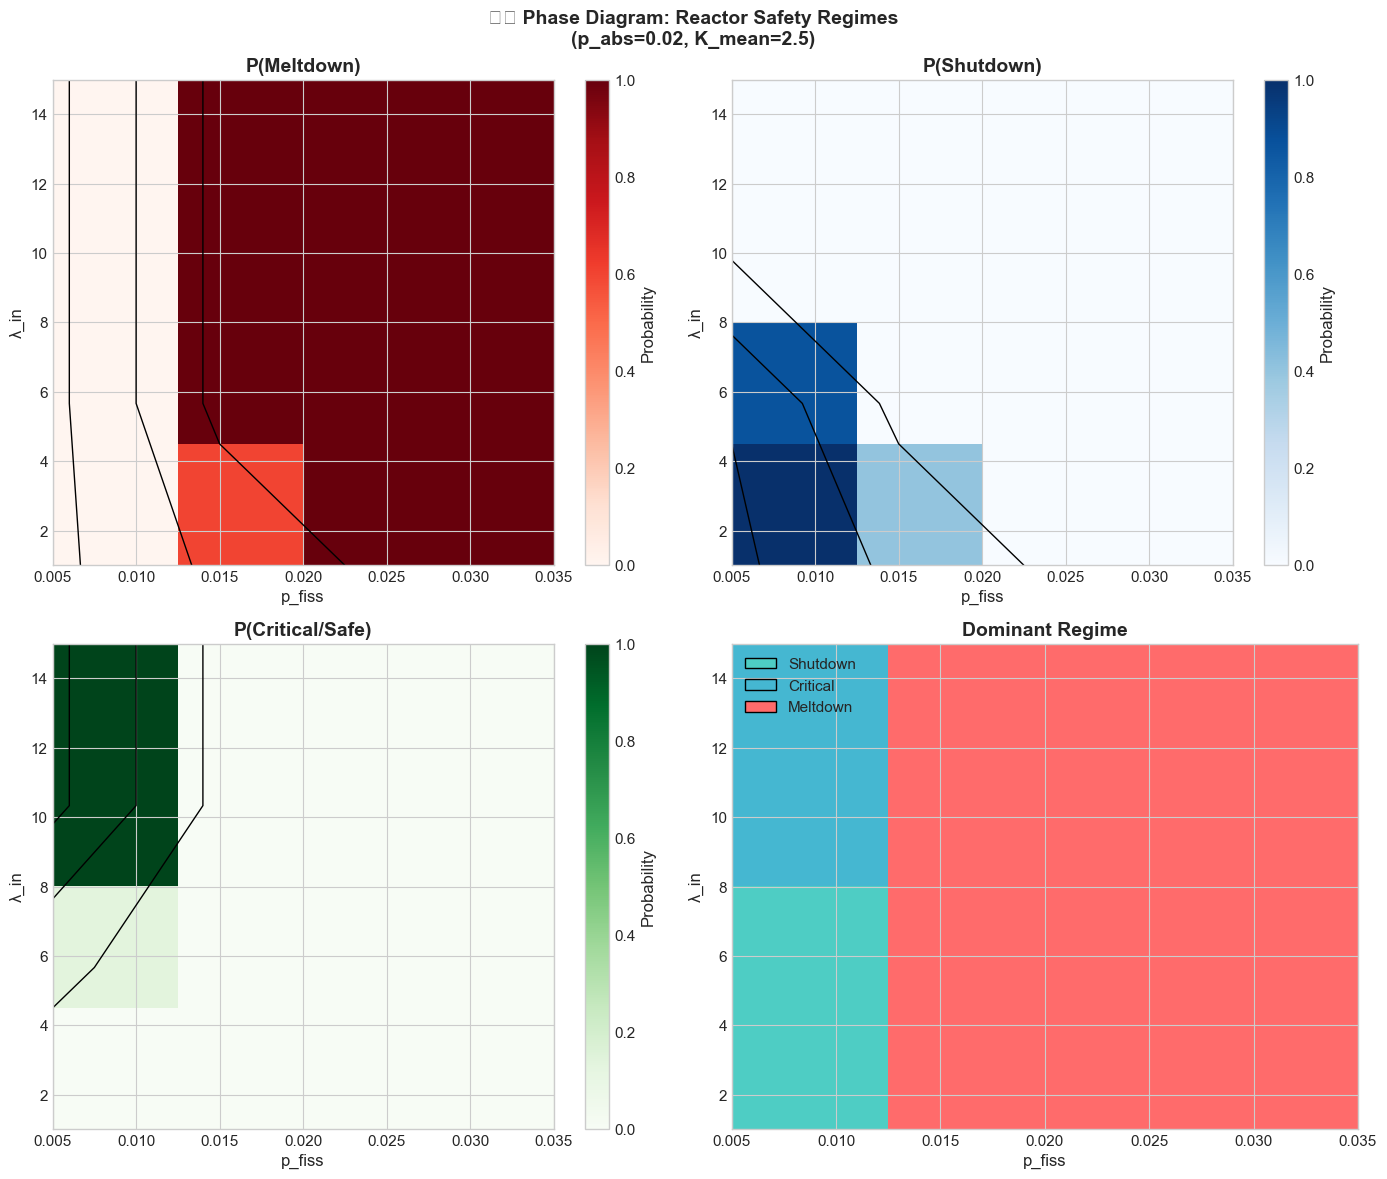

In [ ]:
def plot_phase_diagram(p_fiss_range, lambda_range, P_melt, P_shut, P_crit, base_params):
    """
    Plot comprehensive phase diagram.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    extent = [p_fiss_range[0], p_fiss_range[-1], lambda_range[0], lambda_range[-1]]

    # === Panel 1: Meltdown probability ===
    ax1 = axes[0, 0]
    im1 = ax1.imshow(P_melt, origin='lower', aspect='auto', cmap='Reds',
                    extent=extent, vmin=0, vmax=1)
    ax1.contour(p_fiss_range, lambda_range, P_melt,
               levels=[0.1, 0.5, 0.9], colors='black', linewidths=1)
    plt.colorbar(im1, ax=ax1, label='Probability')
    ax1.set_xlabel('p_fiss')
    ax1.set_ylabel('λ_in')
    ax1.set_title('P(Meltdown)', fontweight='bold')

    # === Panel 2: Shutdown probability ===
    ax2 = axes[0, 1]
    im2 = ax2.imshow(P_shut, origin='lower', aspect='auto', cmap='Blues',
                    extent=extent, vmin=0, vmax=1)
    ax2.contour(p_fiss_range, lambda_range, P_shut,
               levels=[0.1, 0.5, 0.9], colors='black', linewidths=1)
    plt.colorbar(im2, ax=ax2, label='Probability')
    ax2.set_xlabel('p_fiss')
    ax2.set_ylabel('λ_in')
    ax2.set_title('P(Shutdown)', fontweight='bold')

    # === Panel 3: Critical probability ===
    ax3 = axes[1, 0]
    im3 = ax3.imshow(P_crit, origin='lower', aspect='auto', cmap='Greens',
                    extent=extent, vmin=0, vmax=1)
    ax3.contour(p_fiss_range, lambda_range, P_crit,
               levels=[0.1, 0.5, 0.9], colors='black', linewidths=1)
    plt.colorbar(im3, ax=ax3, label='Probability')
    ax3.set_xlabel('p_fiss')
    ax3.set_ylabel('λ_in')
    ax3.set_title('P(Critical/Safe)', fontweight='bold')

    # === Panel 4: Dominant regime ===
    ax4 = axes[1, 1]

    n_l, n_p = P_melt.shape
    dominant = np.zeros_like(P_melt)
    for i in range(n_l):
        for j in range(n_p):
            probs = [P_shut[i,j], P_crit[i,j], P_melt[i,j]]
            dominant[i, j] = np.argmax(probs)

    cmap_cat = LinearSegmentedColormap.from_list('regime',
                                                  ['#4ecdc4', '#45b7d1', '#ff6b6b'], N=3)
    im4 = ax4.imshow(dominant, origin='lower', aspect='auto', cmap=cmap_cat,
                    extent=extent, vmin=0, vmax=2)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ecdc4', edgecolor='black', label='Shutdown'),
        Patch(facecolor='#45b7d1', edgecolor='black', label='Critical'),
        Patch(facecolor='#ff6b6b', edgecolor='black', label='Meltdown')
    ]
    ax4.legend(handles=legend_elements, loc='upper left')
    ax4.set_xlabel('p_fiss')
    ax4.set_ylabel('λ_in')
    ax4.set_title('Dominant Regime', fontweight='bold')

    plt.suptitle(f'🗺️ Phase Diagram: Reactor Safety Regimes\n'
                f'(p_abs={base_params.p_abs}, K_mean={base_params.K_mean})',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('09_phase_diagram.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_phase_diagram(p_fiss_range, lambda_range, P_melt, P_shut, P_crit, params)

---
## 16. 📝 Final Summary and Conclusions

In [ ]:
# Print comprehensive summary
print("="*70)
print("  NUCLEAR REACTOR MONTE CARLO SIMULATION - FINAL SUMMARY")
print("="*70)

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║                      SIMULATION SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  BASE CONFIGURATION (M={mc_results['M']} runs):                                    ║
║    • m_eff = {params.m_eff:.4f}                                               ║
║    • P(Meltdown) = {mc_results['meltdown']['probability']:.4f}  ±  {mc_results['meltdown']['std_error']*1.96:.4f}                              ║
║    • P(Shutdown) = {mc_results['shutdown']['probability']:.4f}  ±  {mc_results['shutdown']['std_error']*1.96:.4f}                              ║
║    • P(Critical) = {mc_results['critical']['probability']:.4f}  ±  {mc_results['critical']['std_error']*1.96:.4f}                              ║
║                                                                      ║
║  HYPOTHESIS TEST (Low vs High Fission, M={M_test} per config):              ║
║    Meltdown: p-value = {test_results['meltdown']['p_value']:.6f}  {'✓ SIGNIFICANT' if test_results['meltdown']['significant_05'] else '✗ NOT SIG.'}                ║
║    Shutdown: p-value = {test_results['shutdown']['p_value']:.6f}  {'✓ SIGNIFICANT' if test_results['shutdown']['significant_05'] else '✗ NOT SIG.'}                ║
║    Critical: p-value = {test_results['critical']['p_value']:.6f}  {'✓ SIGNIFICANT' if test_results['critical']['significant_05'] else '✗ NOT SIG.'}                ║
║                                                                      ║
║  KEY FINDINGS:                                                       ║
║    • Increasing p_fiss shifts outcomes toward meltdown               ║
║    • Higher λ_in provides more fuel, reducing shutdown probability   ║
║    • Critical regime exists in a narrow parameter band               ║
║    • Queue dynamics provide stabilizing external neutron source      ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")

print("\n📁 Generated Figures:")
print("  01_brownian_motion.png      - Brownian motion visualization")
print("  02_branching_process.png    - Branching process dynamics")
print("  03_single_simulation.png    - Detailed single run analysis")
print("  04_monte_carlo_results.png  - MC estimation results")
print("  05_ensemble_trajectories.png - Trajectory variability")
print("  06_sweep_p_fiss.png         - Fission probability sweep")
print("  07_sweep_lambda.png         - Arrival rate sweep")
print("  08_hypothesis_test.png      - Configuration comparison")
print("  09_phase_diagram.png        - 2D phase diagram")

print("\n" + "="*70)
print("  ✓ SIMULATION COMPLETE!")
print("="*70)

  NUCLEAR REACTOR MONTE CARLO SIMULATION - FINAL SUMMARY

╔══════════════════════════════════════════════════════════════════════╗
║                      SIMULATION SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  BASE CONFIGURATION (M=10 runs):                                    ║
║    • m_eff = 0.0375                                               ║
║    • P(Meltdown) = 1.0000  ±  0.0000                              ║
║    • P(Shutdown) = 0.0000  ±  0.0000                              ║
║    • P(Critical) = 0.0000  ±  0.0000                              ║
║                                                                      ║
║  HYPOTHESIS TEST (Low vs High Fission, M=10 per config):              ║
║    Meltdown: p-value = 0.000008  ✓ SIGNIFICANT                ║
║    Shutdown: p-value = 0.001032  ✓ SIGNIFICANT                ║
║    Critical: p-va

---
## References

1. **Brownian Motion**: Einstein, A. (1905). "Über die von der molekularkinetischen Theorie der Wärme geforderte Bewegung von in ruhenden Flüssigkeiten suspendierten Teilchen."

2. **Branching Processes**: Harris, T.E. (1963). "The Theory of Branching Processes." Springer.

3. **Monte Carlo Methods**: Kroese, D.P., Taimre, T., & Botev, Z.I. (2011). "Handbook of Monte Carlo Methods." Wiley.

4. **Queueing Theory**: Kleinrock, L. (1975). "Queueing Systems, Volume 1: Theory." Wiley.

5. **Nuclear Reactor Physics**: Duderstadt, J.J., & Hamilton, L.J. (1976). "Nuclear Reactor Analysis." Wiley.